<a href="https://colab.research.google.com/github/Abdulhamid97Mousa/Bearing-Fault-Diagnosis-Method-Based-on-Spectrum-Map-Information-Fusion-and-Convolutional-Neural-Net/blob/main/Bearing_Fault_Diagnosis_using_Convolutional_Neural_Networks_and_Vibration_Spectrogram_CWRU_DS_10_Classes_DATASET_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Bearing Fault Diagnosis Method Based on Spectrum Map Information Fusion and Convolutional Neural Network

This is a reproduced implementation of the following publication
- I tried to reproduce it and their might be some differences between my code implementation and the author's implementation, Please visit the website to read the article:
https://www.mdpi.com/2227-9717/10/7/1426/htm

the proposed method, vibration signals are represented by
spectrograms to apply deep learning methods through preprocessing using Short-Time Fourier
Transform (STFT). Then, feature extraction and health status classification are performed by a
convolutional neural network (CNN), Resnet18. According to various experiments, our proposed
method can achieve very high accuracy and robustness for bearing fault diagnosis even under
noisy environments.

# 1. Introduction
The dataset that have been used here are - CWRU

* The first dataset is from the Case Western Reserve University. This is used to classify faults using a CNN (Convolutional Neural Network).


## 1.1 Import Necessary Libraries
We'll be using the following libraries to complete our classification problem:

*  Numpy - For linear algebra operations
*  Torch - Pytorch Deep Learning Framework
*  Torch NN - Neural network class from Pytorch library
*  Torch NN Functional - Functional Neural Network class from Pytorch library
*  Torch Utils Data: DataLoader, Dataset - Dataset class used to create custom dataset class by subclassing it and DataLoader is used to laod data in batches using dataset class in real-time.
*  Torchvision: Transforms, Models - Trochvision provides augmentation techniques using transforms class and transfer learning models are available in models class
*  OS - To use Operating System methods
*  Random - To set random seed at specific places where random operations take place just so it happens the same way everytime it is executed
*  Pandas - To create DataFrame, CSV files, etc
*  Time - To perform date time operations


*  Scikit-Learn - For evaluating our Classifier and for cross-validation split
*  matplotlib - To visualize images, losses and accuracy
*  Google Colab Drive - To mount Google Drive so we can perform storage and loading operations using it

In [107]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import errno
import requests

from os import listdir
from os.path import isfile, join
from zipfile import ZipFile 


# Others
from IPython.core.debugger import set_trace
from pathlib import Path

# Pytorch
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from torch.nn.modules.loss import CrossEntropyLoss
from torchvision import models
from torch import optim, cuda
from torch.utils.data import  sampler
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torchvision import datasets,transforms

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [108]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
print(os.getcwd())
filename = os.path.join(os.getcwd(), 'repo.zip')
print(filename)

/content
/content/repo.zip


In [5]:
url = 'https://github.com/Abdulhamid97Mousa/CWRU-dataset-1/archive/refs/heads/main.zip'

r = requests.get(url)

print(filename)

with open(filename, 'wb') as f:
    f.write(r.content) 

file_name = "/content/repo.zip"
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Finished Extracting!') 

/content/repo.zip
Extracting all the files now...
Finished Extracting!


In [110]:
import re
import numpy as np
import scipy.io as sio
import os

from os import listdir
from os.path import isfile, join
from zipfile import ZipFile
from sklearn.model_selection import train_test_split

def acceleration_time_signal(dict_1, code):
    """
    load the time series in the file and convert units in SI
    file= 'filename' from the ./dataset/ folder
    code= ' DE' or 'FE', other code will give error
    """

    try:
        for key in dict_1:
            # print(key)
            if re.findall(rf"({code})", key):
                dict_code = key
        # inches to meter
        unit_conv = 0.0254
        x = dict_1[dict_code] * unit_conv
        return x
    except:
        print('File does not exist or code wrong. Code must be either "DE or "FE" ')


def Read_MAT_files_from_folders(file_path, files_list, code):
  G_data = []
  for i in range(len(files_list)):
    data = sio.loadmat(os.path.join(file_path, files_list[i]))
    sig = acceleration_time_signal(data, code)
    # print('what is signal type and sig len and signal shape', type(sig), len(sig), sig.shape)
    G_data.append(sig)
  
  G_data = np.vstack(G_data).flatten()
  # print("what is G_data", G_data)
  return G_data 


def Percent_data_split(array_1, array_2, percent_1=10, index_1=False):
    if index_1 == False:
        # splitting FE data by percent
        len_n = array_1.shape[0]
        percent_true = percent_1 / 100
        x = int(percent_true * len_n)  # % split
        data_percent, data_rest = np.split(array_1, [x])
    else:
        # splitting array_1 data by percent of array_2 data
        len_n = array_2.shape[0]
        percent_true = percent_1 / 100
        x = int(percent_true * len_n)  # % split
        data_percent, data_rest = np.split(array_1, [x])

    return data_percent, data_rest


def fast_scandir(dirname):
    subfolders = [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders

In [ ]:
# import sys    
# path_to_module = '/content/drive/MyDrive/Utility'
# sys.path.append(path_to_module)
# from Model_Utilities import Read_MAT_files_from_folders, Percent_data_split, fast_scandir, acceleration_time_signal

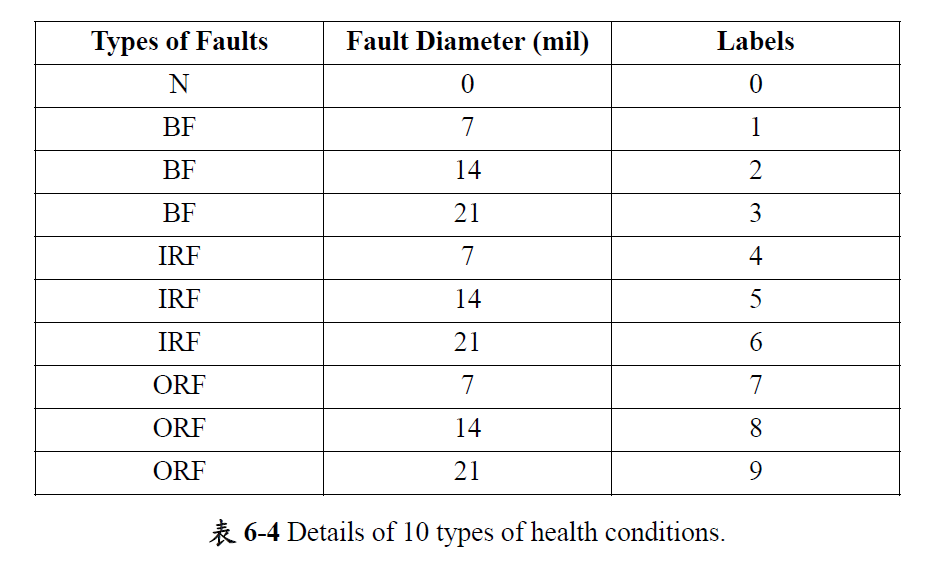

#DATASET_A

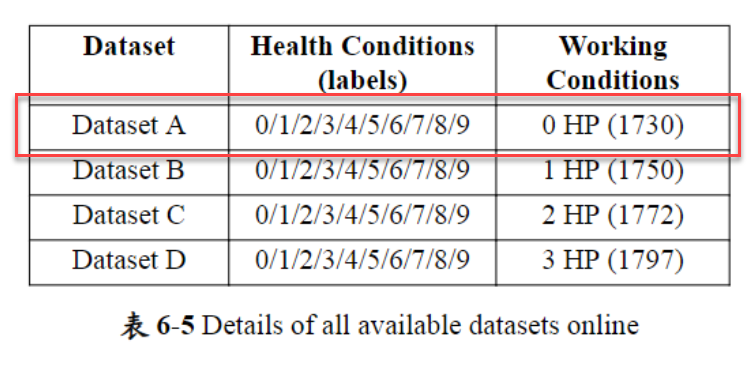

In [111]:
#12k Normal Signal for DE
file_path_1 = '/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_A/Normal'
onlyfiles_1 = [f for f in listdir(file_path_1) if isfile(join(file_path_1, f))]

print(onlyfiles_1)
print(type(onlyfiles_1))
print(len(onlyfiles_1))

G_data_N_DE_DATASET_A = Read_MAT_files_from_folders(file_path_1, onlyfiles_1, "DE")

print(G_data_N_DE_DATASET_A.shape)
print(type(G_data_N_DE_DATASET_A))

['97_Normal_0.mat']
<class 'list'>
1
(243938,)
<class 'numpy.ndarray'>


In [112]:
#12k DE data load
file_path_2 = '/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_A/12k_Drive_End_Bearing_Fault_Data'
subfolder_path = fast_scandir(file_path_2)

G_data_OR_007_DE = []
G_data_OR_021_DE = []

for i in range(3, len(subfolder_path), 1):
  dir_1 = subfolder_path[i]
  print(subfolder_path[i])
  #B
  if 'B/' in dir_1:
    onlyfiles_2_1 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]

    if '007' in dir_1:
    #007
      G_data_B_007_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    elif '014' in dir_1:
    #014
      G_data_B_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    elif '021' in dir_1:
    #021
      G_data_B_021_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    else:
    #028
      G_data_B_028_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")


  #IR
  elif 'IR/' in dir_1:
    onlyfiles_2_2 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]

    if '007' in dir_1:
    #007
      G_data_IR_007_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    elif '014' in dir_1:
    #014
      G_data_IR_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    elif '021' in dir_1:
    #021
      G_data_IR_021_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    else:
    #028
      G_data_IR_028_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")


  #OR
  elif 'OR/' in dir_1:
    
    onlyfiles_2_3 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]
    
    if '007' in dir_1:

      #007
      for i in range(len(onlyfiles_2_3)):
        data_OR_007 = sio.loadmat(os.path.join(dir_1, onlyfiles_2_3[i]))
        or_sig_007 = acceleration_time_signal(data_OR_007, code='DE')
        G_data_OR_007_DE.append(or_sig_007)

      #014  
    elif '014' in dir_1:
      G_data_OR_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_3, "DE")


      #021
    else:
      for i in range(len(onlyfiles_2_3)):
        data_OR_021 = sio.loadmat(os.path.join(dir_1, onlyfiles_2_3[i]))
        or_sig_021 = acceleration_time_signal(data_OR_021, code='DE')
        G_data_OR_021_DE.append(or_sig_021)


/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_A/12k_Drive_End_Bearing_Fault_Data/OR/021
/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_A/12k_Drive_End_Bearing_Fault_Data/OR/007
/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_A/12k_Drive_End_Bearing_Fault_Data/OR/014
/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_A/12k_Drive_End_Bearing_Fault_Data/OR/021/@3
/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_A/12k_Drive_End_Bearing_Fault_Data/OR/021/@6
/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_A/12k_Drive_End_Bearing_Fault_Data/OR/021/@12
/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_A/12k_Drive_End_Bearing_Fault_Data/OR/007/@3
/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_A/12k_Drive_End_Bearing_Fault_Data/OR/007/@6
/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_A/12k_Drive_End_Bearing_Fault_Data/OR/007/@12
/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_A/12k_Drive_End_Bearing_Fault_Data/IR/021
/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset

In [113]:
print("G_data_B_007_DE", G_data_B_007_DE.shape)
print("G_data_B_014_DE", G_data_B_014_DE.shape)
print("G_data_B_021_DE", G_data_B_021_DE.shape)

G_data_B_DE = np.concatenate((G_data_B_007_DE, G_data_B_014_DE, G_data_B_021_DE), axis=0).flatten()
print("G_data_B_DE", G_data_B_DE.shape)
print("G_data_B_DE type", type(G_data_B_DE))

print("G_data_IR_007_DE", G_data_IR_007_DE.shape)
print("G_data_IR_014_DE", G_data_IR_014_DE.shape)
print("G_data_IR_021_DE", G_data_IR_021_DE.shape)

G_data_IR_DE = np.concatenate((G_data_IR_007_DE, G_data_IR_014_DE,
                               G_data_IR_021_DE), axis=0).flatten()
print("G_data_IR_DE", G_data_IR_DE.shape)

G_data_OR_007_DE = np.vstack(G_data_OR_007_DE).flatten()
print("G_data_OR_007_DE", G_data_OR_007_DE.shape)
G_data_OR_014_DE = np.vstack(G_data_OR_014_DE).flatten()
print("G_data_OR_014_DE", np.shape(G_data_OR_014_DE))
G_data_OR_021_DE = np.vstack(G_data_OR_021_DE).flatten()
print("G_data_OR_021_DE", G_data_OR_021_DE.shape)
G_data_OR_DE = np.concatenate((G_data_OR_007_DE, G_data_OR_014_DE, 
                               G_data_OR_021_DE), axis=0).flatten()
print("G_data_OR_DE", np.shape(G_data_OR_DE))  
print("G_data_N_DE.shape", G_data_N_DE_DATASET_A.shape)

# 
G_data_faulty_DE = np.concatenate((G_data_B_007_DE, G_data_B_014_DE, G_data_B_021_DE, G_data_IR_007_DE,
                                G_data_IR_014_DE, G_data_IR_021_DE, G_data_OR_007_DE, G_data_OR_014_DE, G_data_OR_021_DE), axis=0).flatten()
print("G_data_faulty.shape", G_data_faulty_DE.shape)       

G_data_B_007_DE (122571,)
G_data_B_014_DE (121846,)
G_data_B_021_DE (121991,)
G_data_B_DE (366408,)
G_data_B_DE type <class 'numpy.ndarray'>
G_data_IR_007_DE (121265,)
G_data_IR_014_DE (121846,)
G_data_IR_021_DE (122136,)
G_data_IR_DE (365247,)
G_data_OR_007_DE (366553,)
G_data_OR_014_DE (121846,)
G_data_OR_021_DE (365973,)
G_data_OR_DE (854372,)
G_data_N_DE.shape (243938,)
G_data_faulty.shape (1586027,)


In [114]:
G_data_B_007_DE_DATASET_A = G_data_B_007_DE 
G_data_B_014_DE_DATASET_A = G_data_B_014_DE 
G_data_B_021_DE_DATASET_A = G_data_B_021_DE 
G_data_B_DE_DATASET_A = G_data_B_DE 
G_data_IR_007_DE_DATASET_A = G_data_IR_007_DE 
G_data_IR_014_DE_DATASET_A = G_data_IR_014_DE 
G_data_IR_021_DE_DATASET_A = G_data_IR_021_DE 
G_data_IR_DE_DATASET_A = G_data_IR_DE 
G_data_OR_007_DE_DATASET_A = G_data_OR_007_DE 
G_data_OR_014_DE_DATASET_A = G_data_OR_014_DE 
G_data_OR_021_DE_DATASET_A = G_data_OR_021_DE 
G_data_OR_DE_DATASET_A = G_data_OR_DE
G_data_N_DE_DATASET_A =  G_data_N_DE_DATASET_A
G_data_faulty_DATASET_A = G_data_faulty_DE

In [115]:
print("Level #1 Bearing Status")
print("G_data_N_DE.shape", G_data_N_DE_DATASET_A.shape)
print("G_data_faulty.shape", G_data_faulty_DATASET_A.shape) 

print("Level #2 Bearing Fault Location")
print("G_data_N_DE.shape", G_data_N_DE_DATASET_A.shape)
print("G_data_B_DE", G_data_B_DE_DATASET_A.shape)
print("G_data_IR_DE", G_data_IR_DE_DATASET_A.shape)
print("G_data_OR_DE", np.shape(G_data_OR_DE_DATASET_A))

print("Level #3 Bearing Fault Diameter")
print("G_data_N_DE.shape", G_data_N_DE_DATASET_A.shape)
print("G_data_B_007_DE", G_data_B_007_DE_DATASET_A.shape)
print("G_data_B_014_DE", G_data_B_014_DE_DATASET_A.shape)
print("G_data_B_021_DE", G_data_B_021_DE_DATASET_A.shape)
print("G_data_IR_007_DE", G_data_IR_007_DE_DATASET_A.shape)
print("G_data_IR_014_DE", G_data_IR_014_DE_DATASET_A.shape)
print("G_data_IR_021_DE", G_data_IR_021_DE_DATASET_A.shape)
print("G_data_OR_007_DE", G_data_OR_007_DE_DATASET_A.shape)
print("G_data_OR_014_DE", np.shape(G_data_OR_014_DE_DATASET_A))
print("G_data_OR_021_DE", G_data_OR_021_DE_DATASET_A.shape)

Level #1 Bearing Status
G_data_N_DE.shape (243938,)
G_data_faulty.shape (1586027,)
Level #2 Bearing Fault Location
G_data_N_DE.shape (243938,)
G_data_B_DE (366408,)
G_data_IR_DE (365247,)
G_data_OR_DE (854372,)
Level #3 Bearing Fault Diameter
G_data_N_DE.shape (243938,)
G_data_B_007_DE (122571,)
G_data_B_014_DE (121846,)
G_data_B_021_DE (121991,)
G_data_IR_007_DE (121265,)
G_data_IR_014_DE (121846,)
G_data_IR_021_DE (122136,)
G_data_OR_007_DE (366553,)
G_data_OR_014_DE (121846,)
G_data_OR_021_DE (365973,)


#DATASET_B

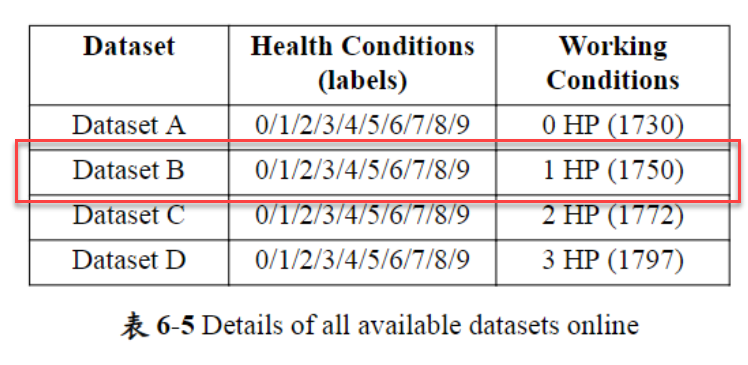

In [116]:
#12k Normal Signal for DE
file_path_1 = '/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_B/Normal'
onlyfiles_1 = [f for f in listdir(file_path_1) if isfile(join(file_path_1, f))]

print(onlyfiles_1)
print(type(onlyfiles_1))
print(len(onlyfiles_1))

G_data_N_DE_DATASET_B = Read_MAT_files_from_folders(file_path_1, onlyfiles_1, "DE")

print(G_data_N_DE_DATASET_B.shape)
print(type(G_data_N_DE_DATASET_B))

['98_Normal_1.mat']
<class 'list'>
1
(483903,)
<class 'numpy.ndarray'>


In [117]:
#12k DE data load
file_path_2 = '/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_B/12k_Drive_End_Bearing_Fault_Data'
subfolder_path = fast_scandir(file_path_2)


G_data_OR_007_DE = []
G_data_OR_021_DE = []

for i in range(3, len(subfolder_path), 1):
  dir_1 = subfolder_path[i]
  print(subfolder_path[i])
  #B
  if '12k_Drive_End_Bearing_Fault_Data/B/' in dir_1:
    onlyfiles_2_1 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]

    if '007' in dir_1:
    #007
      print(dir_1)
      G_data_B_007_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    elif '014' in dir_1:
    #014
      G_data_B_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    elif '021' in dir_1:
    #021
      G_data_B_021_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    else:
    #028
      G_data_B_028_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")


  #IR
  elif 'IR/' in dir_1:
    onlyfiles_2_2 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]

    if '007' in dir_1:
    #007
      G_data_IR_007_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    elif '014' in dir_1:
    #014
      G_data_IR_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    elif '021' in dir_1:
    #021
      G_data_IR_021_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    else:
    #028
      G_data_IR_028_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")


  #OR
  elif 'OR/' in dir_1:
    
    onlyfiles_2_3 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]
    
    if '007' in dir_1:

      #007
      for i in range(len(onlyfiles_2_3)):
        data_OR_007 = sio.loadmat(os.path.join(dir_1, onlyfiles_2_3[i]))
        or_sig_007 = acceleration_time_signal(data_OR_007, code='DE')
        G_data_OR_007_DE.append(or_sig_007)

      #014  
    elif '014' in dir_1:
      G_data_OR_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_3, "DE")


      #021
    else:
      for i in range(len(onlyfiles_2_3)):
        data_OR_021 = sio.loadmat(os.path.join(dir_1, onlyfiles_2_3[i]))
        or_sig_021 = acceleration_time_signal(data_OR_021, code='DE')
        G_data_OR_021_DE.append(or_sig_021)


/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_B/12k_Drive_End_Bearing_Fault_Data/OR/021
/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_B/12k_Drive_End_Bearing_Fault_Data/OR/007
/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_B/12k_Drive_End_Bearing_Fault_Data/OR/014
/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_B/12k_Drive_End_Bearing_Fault_Data/OR/021/@3
/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_B/12k_Drive_End_Bearing_Fault_Data/OR/021/@6
/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_B/12k_Drive_End_Bearing_Fault_Data/OR/021/@12
/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_B/12k_Drive_End_Bearing_Fault_Data/OR/007/@3
/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_B/12k_Drive_End_Bearing_Fault_Data/OR/007/@6
/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_B/12k_Drive_End_Bearing_Fault_Data/OR/007/@12
/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset_B/12k_Drive_End_Bearing_Fault_Data/IR/021
/content/CWRU-dataset-1-main/Datasets_ABDC/Dataset

In [118]:
print("G_data_B_007_DE", G_data_B_007_DE.shape)
print("G_data_B_014_DE", G_data_B_014_DE.shape)
print("G_data_B_021_DE", G_data_B_021_DE.shape)

G_data_B_DE = np.concatenate((G_data_B_007_DE, G_data_B_014_DE, G_data_B_021_DE), axis=0).flatten()
print("G_data_B_DE", G_data_B_DE.shape)
print("G_data_B_DE type", type(G_data_B_DE))

print("G_data_IR_007_DE", G_data_IR_007_DE.shape)
print("G_data_IR_014_DE", G_data_IR_014_DE.shape)
print("G_data_IR_021_DE", G_data_IR_021_DE.shape)

G_data_IR_DE = np.concatenate((G_data_IR_007_DE, G_data_IR_014_DE,
                               G_data_IR_021_DE), axis=0).flatten()
print("G_data_IR_DE", G_data_IR_DE.shape)

G_data_OR_007_DE = np.vstack(G_data_OR_007_DE).flatten()
print("G_data_OR_007_DE", G_data_OR_007_DE.shape)
G_data_OR_014_DE = np.vstack(G_data_OR_014_DE).flatten()
print("G_data_OR_014_DE", np.shape(G_data_OR_014_DE))
G_data_OR_021_DE = np.vstack(G_data_OR_021_DE).flatten()
print("G_data_OR_021_DE", G_data_OR_021_DE.shape)
G_data_OR_DE = np.concatenate((G_data_OR_007_DE, G_data_OR_014_DE, 
                               G_data_OR_021_DE), axis=0).flatten()
print("G_data_OR_DE", np.shape(G_data_OR_DE))  
print("G_data_N_DE.shape", G_data_N_DE_DATASET_A.shape)

# 
G_data_faulty_DE = np.concatenate((G_data_B_007_DE, G_data_B_014_DE, G_data_B_021_DE, G_data_IR_007_DE,
                                G_data_IR_014_DE, G_data_IR_021_DE, G_data_OR_007_DE, G_data_OR_014_DE, G_data_OR_021_DE), axis=0).flatten()
print("G_data_faulty.shape", G_data_faulty_DE.shape)     

G_data_B_007_DE (121410,)
G_data_B_014_DE (122136,)
G_data_B_021_DE (121701,)
G_data_B_DE (365247,)
G_data_B_DE type <class 'numpy.ndarray'>
G_data_IR_007_DE (121991,)
G_data_IR_014_DE (121846,)
G_data_IR_021_DE (121556,)
G_data_IR_DE (365393,)
G_data_OR_007_DE (366263,)
G_data_OR_014_DE (122136,)
G_data_OR_021_DE (366408,)
G_data_OR_DE (854807,)
G_data_N_DE.shape (243938,)
G_data_faulty.shape (1585447,)


In [119]:
G_data_B_007_DE_DATASET_B = G_data_B_007_DE 
G_data_B_014_DE_DATASET_B = G_data_B_014_DE 
G_data_B_021_DE_DATASET_B = G_data_B_021_DE 
G_data_B_DE_DATASET_B = G_data_B_DE 
G_data_IR_007_DE_DATASET_B = G_data_IR_007_DE 
G_data_IR_014_DE_DATASET_B = G_data_IR_014_DE 
G_data_IR_021_DE_DATASET_B = G_data_IR_021_DE 
G_data_IR_DE_DATASET_B = G_data_IR_DE 
G_data_OR_007_DE_DATASET_B = G_data_OR_007_DE 
G_data_OR_014_DE_DATASET_B = G_data_OR_014_DE 
G_data_OR_021_DE_DATASET_B = G_data_OR_021_DE 
G_data_OR_DE_DATASET_B = G_data_OR_DE
G_data_N_DE_DATASET_B =  G_data_N_DE_DATASET_A
G_data_faulty_DATASET_B = G_data_faulty_DE

In [120]:
print("Level #1 Bearing Status")
print("G_data_N_DE.shape", G_data_N_DE_DATASET_B.shape)
print("G_data_faulty.shape", G_data_faulty_DATASET_B.shape) 

print("Level #2 Bearing Fault Location")
print("G_data_N_DE.shape", G_data_N_DE_DATASET_B.shape)
print("G_data_B_DE", G_data_B_DE_DATASET_B.shape)
print("G_data_IR_DE", G_data_IR_DE_DATASET_B.shape)
print("G_data_OR_DE", np.shape(G_data_OR_DE_DATASET_B))

print("Level #3 Bearing Fault Diameter")
print("G_data_N_DE.shape", G_data_N_DE_DATASET_B.shape)
print("G_data_B_007_DE", G_data_B_007_DE_DATASET_B.shape)
print("G_data_B_014_DE", G_data_B_014_DE_DATASET_B.shape)
print("G_data_B_021_DE", G_data_B_021_DE_DATASET_B.shape)
print("G_data_IR_007_DE", G_data_IR_007_DE_DATASET_B.shape)
print("G_data_IR_014_DE", G_data_IR_014_DE_DATASET_B.shape)
print("G_data_IR_021_DE", G_data_IR_021_DE_DATASET_B.shape)
print("G_data_OR_007_DE", G_data_OR_007_DE_DATASET_B.shape)
print("G_data_OR_014_DE", np.shape(G_data_OR_014_DE_DATASET_B))
print("G_data_OR_021_DE", G_data_OR_021_DE_DATASET_B.shape)

Level #1 Bearing Status
G_data_N_DE.shape (243938,)
G_data_faulty.shape (1585447,)
Level #2 Bearing Fault Location
G_data_N_DE.shape (243938,)
G_data_B_DE (365247,)
G_data_IR_DE (365393,)
G_data_OR_DE (854807,)
Level #3 Bearing Fault Diameter
G_data_N_DE.shape (243938,)
G_data_B_007_DE (121410,)
G_data_B_014_DE (122136,)
G_data_B_021_DE (121701,)
G_data_IR_007_DE (121991,)
G_data_IR_014_DE (121846,)
G_data_IR_021_DE (121556,)
G_data_OR_007_DE (366263,)
G_data_OR_014_DE (122136,)
G_data_OR_021_DE (366408,)


### 3.2.3 Plot - CWRU
Some signals are plotted for the position code = DE of the train data. The data is sampled at 12kHz, that is 12000 data points per second. Plot is done for 1/10 or 10% of 1 second:

Note: Why are the sampling rates and block sizes all powers of two? In the digital world, the Fast Fourier Transform (FFT) and the Discrete Fourier Transform (DFT) are computer algorithms used to perform a Fourier Transform. The Fast Fourier Transform requires a block size that is a power of two (1024, 2048, 4096, etc.) and is computationally quicker than the DFT, which can use any number of data points. With today’s modern computers, the differences in speed are not as noticeable in the past. But due to historical reasons many data acquisition systems still use power of two numbers.

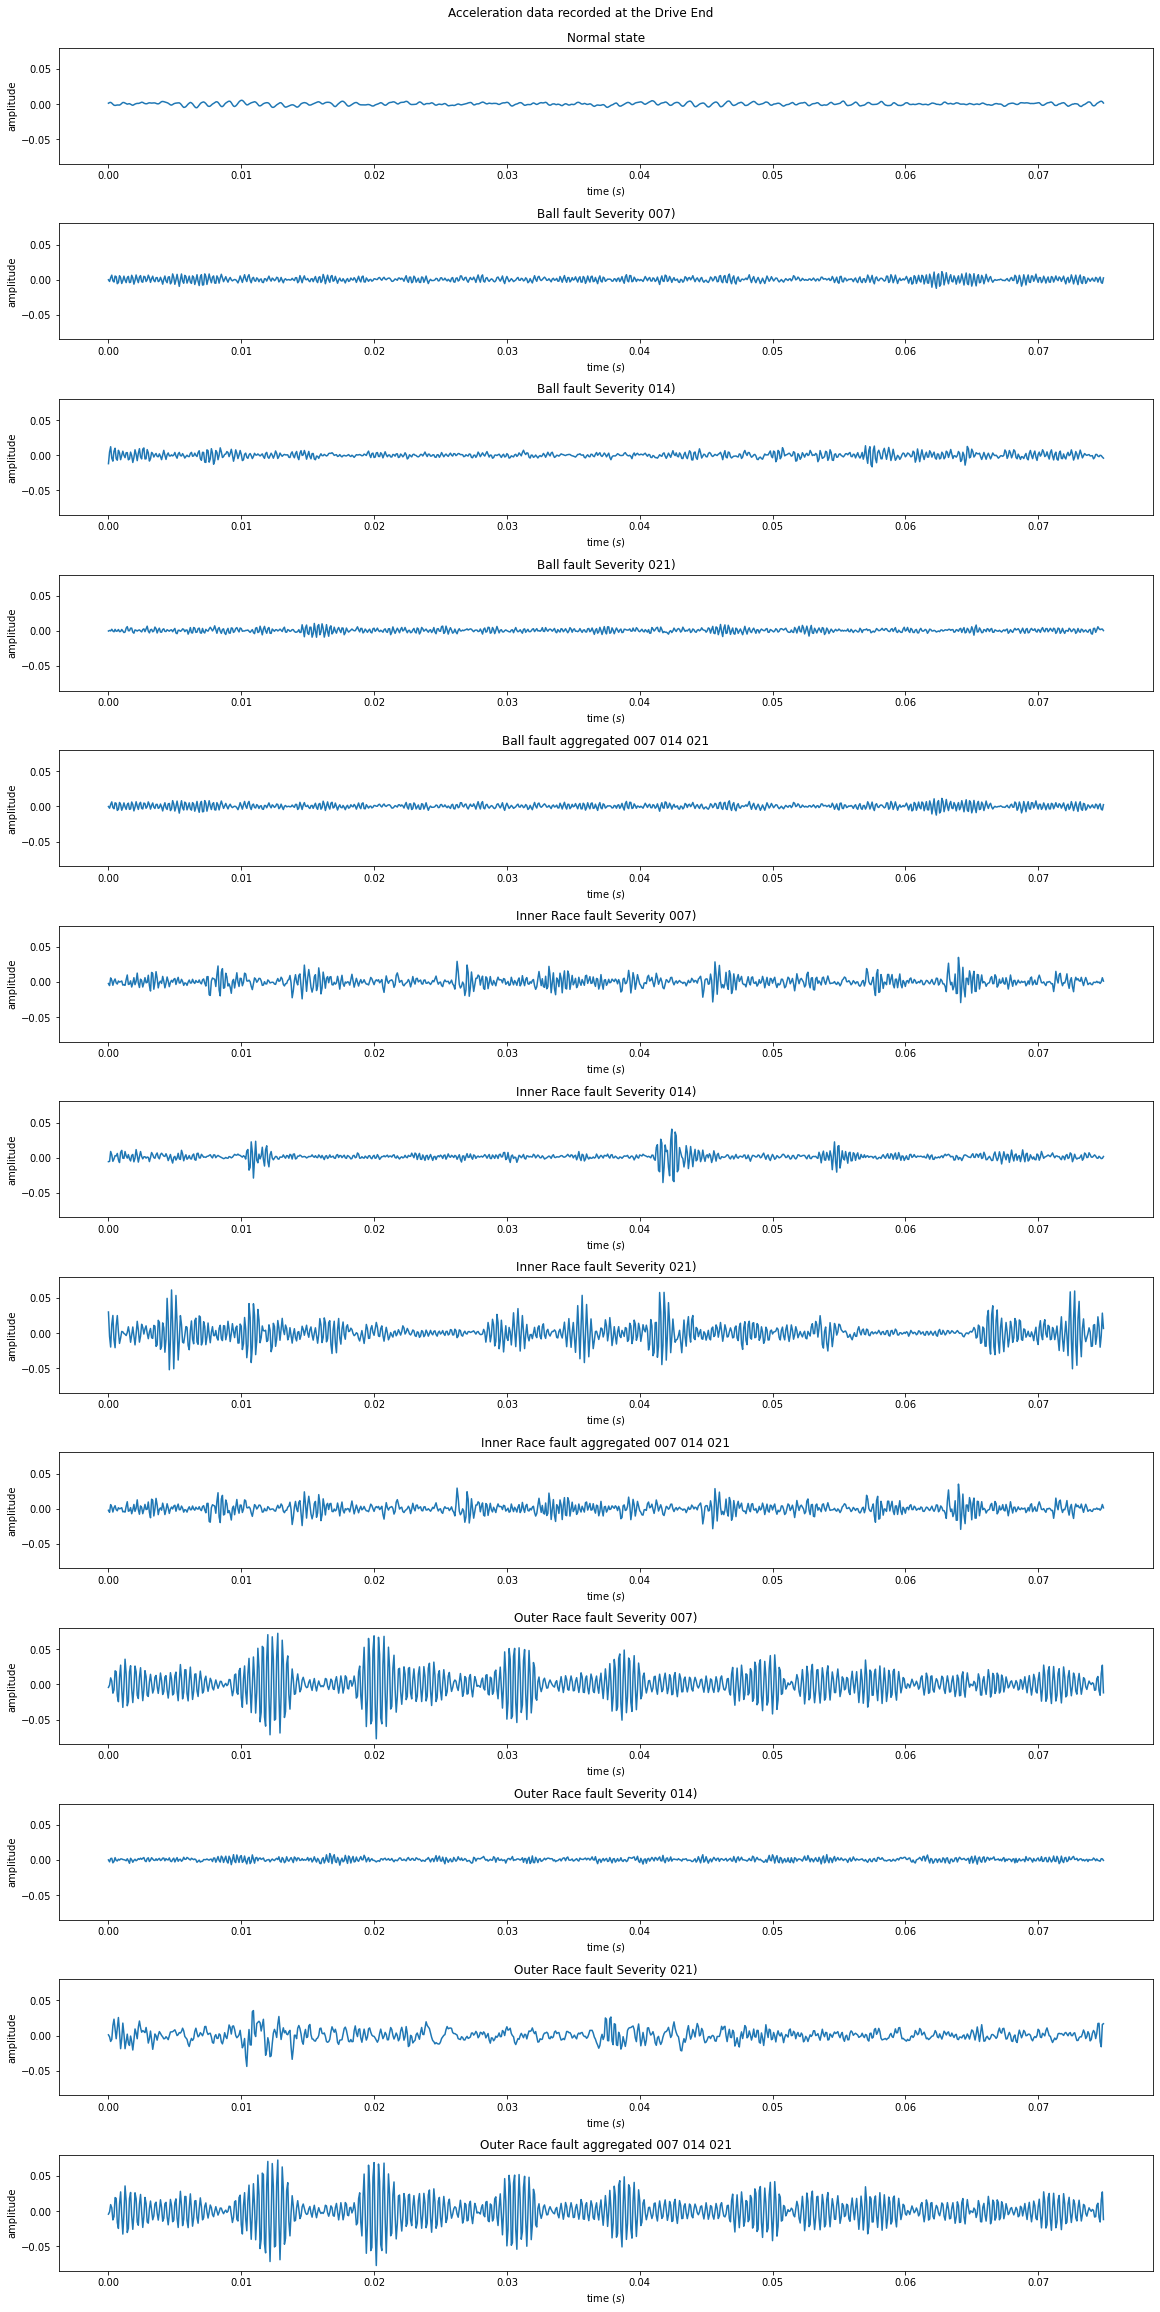

In [121]:
%matplotlib inline
# range_of_samples = np.arange(0,1024)
range_of_samples = np.arange(0,900)
# fs is sampling Rate = 12k
fs = 12000


# plotting
fig, axs = plt.subplots(13, 1, sharey=True, figsize=(16, 32), constrained_layout=True)
fig.suptitle('Acceleration data recorded at the Drive End')

axs[0].plot(range_of_samples/fs, G_data_N_DE_DATASET_A[range_of_samples])
axs[0].set_title('Normal state')

axs[1].plot(range_of_samples/fs, G_data_B_007_DE_DATASET_A[range_of_samples])
axs[1].set_title('Ball fault Severity 007)')

axs[2].plot(range_of_samples/fs, G_data_B_014_DE_DATASET_A[range_of_samples])
axs[2].set_title('Ball fault Severity 014)')

axs[3].plot(range_of_samples/fs, G_data_B_021_DE_DATASET_A[range_of_samples])
axs[3].set_title('Ball fault Severity 021)')

axs[4].plot(range_of_samples/fs, G_data_B_DE_DATASET_A[range_of_samples])
axs[4].set_title('Ball fault aggregated 007 014 021')

axs[5].plot(range_of_samples/fs, G_data_IR_007_DE_DATASET_A[range_of_samples])
axs[5].set_title('Inner Race fault Severity 007)')

axs[6].plot(range_of_samples/fs, G_data_IR_014_DE_DATASET_A[range_of_samples])
axs[6].set_title('Inner Race fault Severity 014)')

axs[7].plot(range_of_samples/fs, G_data_IR_021_DE_DATASET_A[range_of_samples])
axs[7].set_title('Inner Race fault Severity 021)')

axs[8].plot(range_of_samples/fs, G_data_IR_DE_DATASET_A[range_of_samples])
axs[8].set_title('Inner Race fault aggregated 007 014 021')

axs[9].plot(range_of_samples/fs, G_data_OR_007_DE_DATASET_A[range_of_samples])
axs[9].set_title('Outer Race fault Severity 007)')

axs[10].plot(range_of_samples/fs, G_data_OR_014_DE_DATASET_A[range_of_samples])
axs[10].set_title('Outer Race fault Severity 014)')

axs[11].plot(range_of_samples/fs, G_data_OR_021_DE_DATASET_A[range_of_samples])
axs[11].set_title('Outer Race fault Severity 021)')

axs[12].plot(range_of_samples/fs, G_data_OR_DE_DATASET_A[range_of_samples])
axs[12].set_title('Outer Race fault aggregated 007 014 021')

for ax in axs.flat:
    ax.set(xlabel='time $(s)$', ylabel='amplitude')

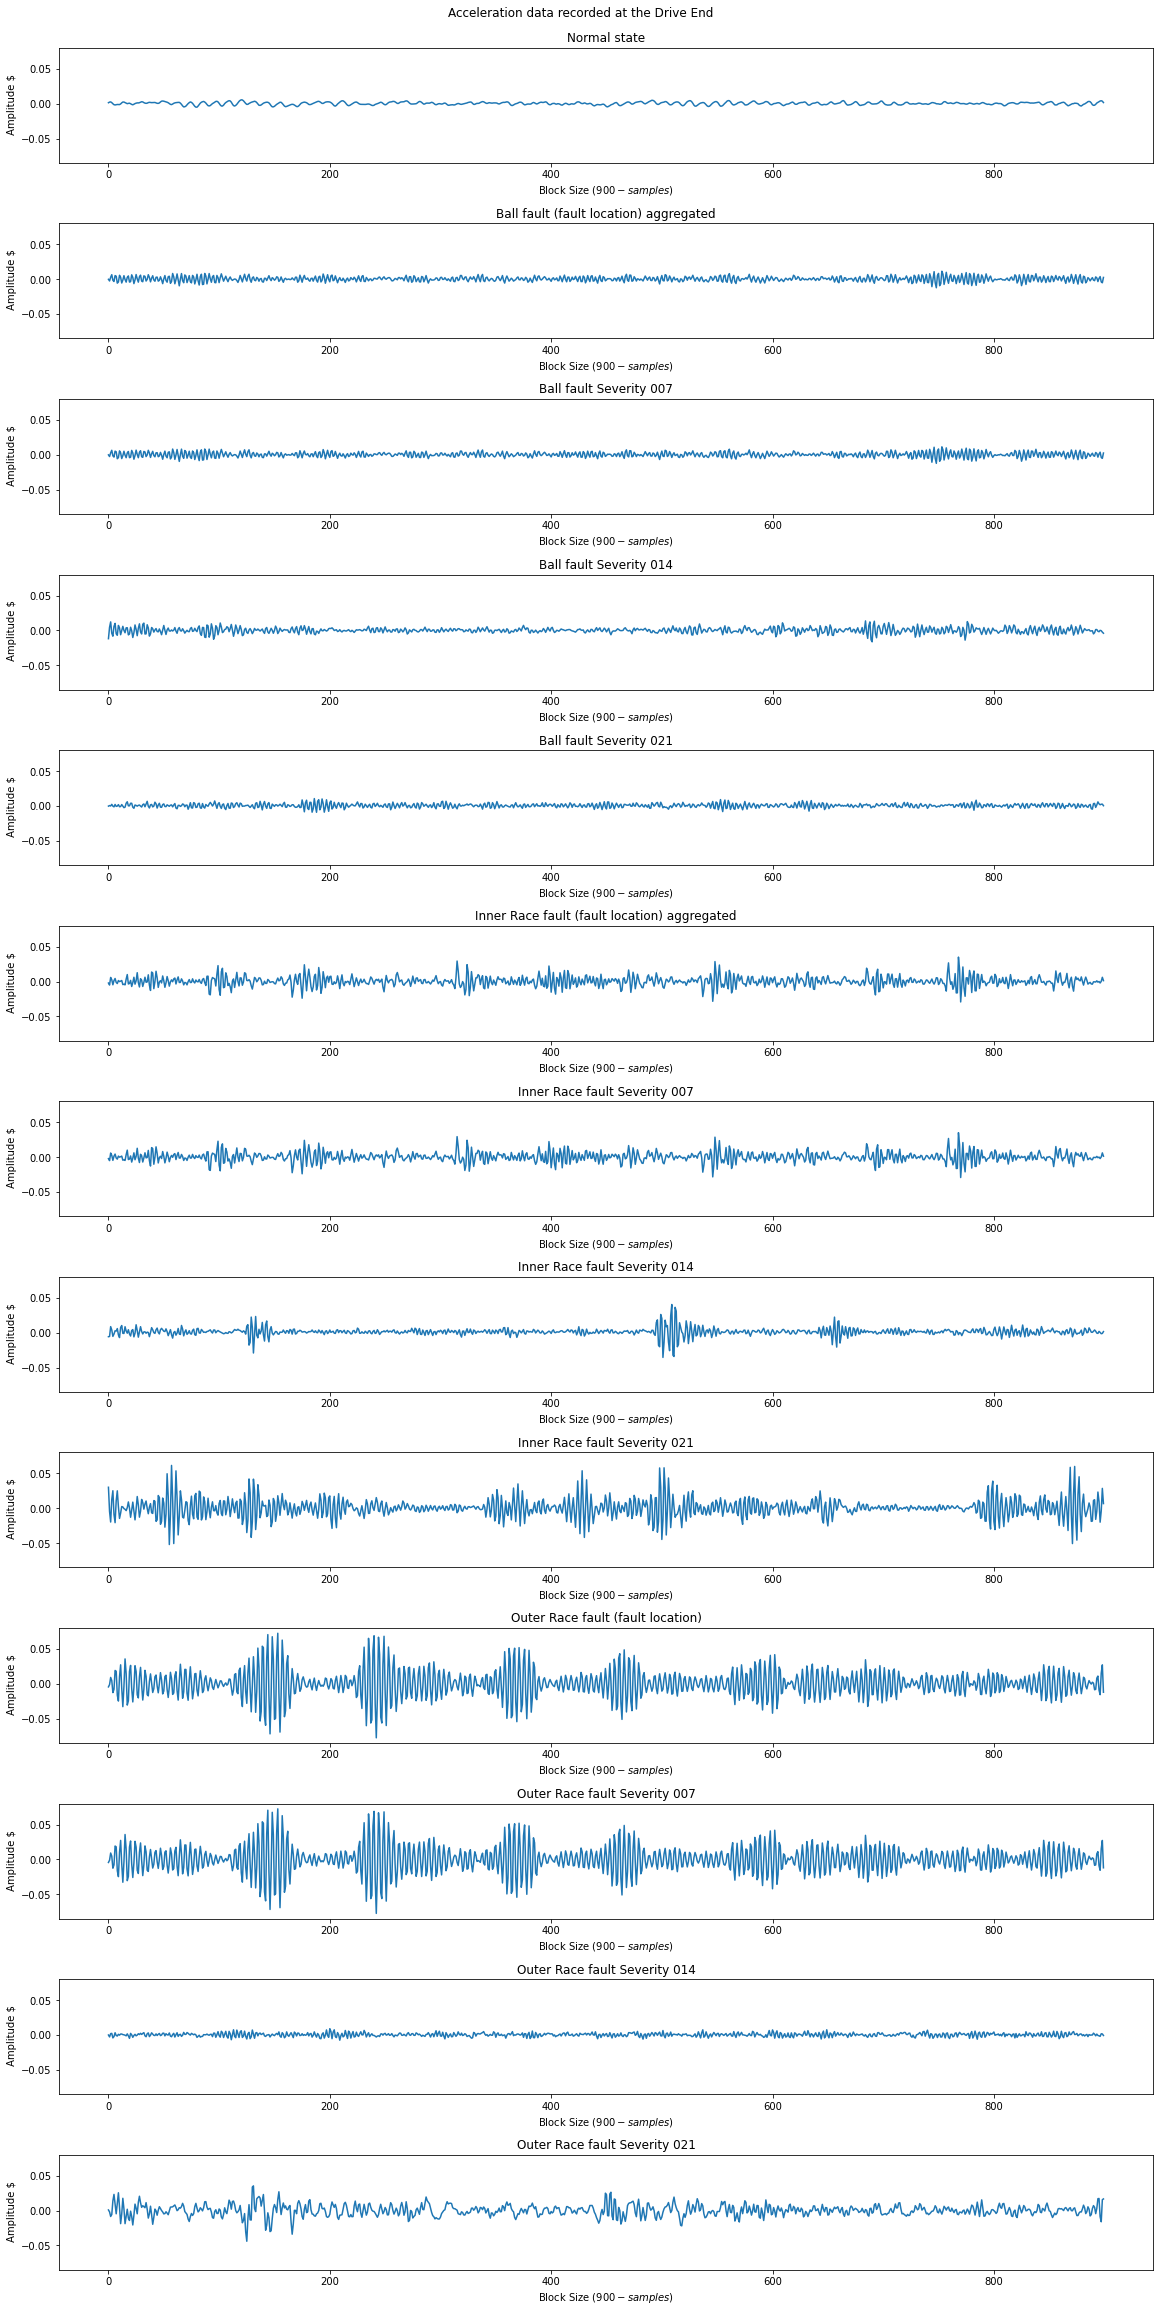

In [122]:
%matplotlib inline

# range_of_samples = np.arange(0,1024)
range_of_samples = np.arange(0,900)
fs = 12000

# plotting
fig, axs = plt.subplots(13, 1, sharey=True, figsize=(16, 32), constrained_layout=True)
fig.suptitle('Acceleration data recorded at the Drive End')

axs[0].plot(G_data_N_DE_DATASET_A[range_of_samples])
axs[0].set_title('Normal state')

axs[1].plot(G_data_B_DE_DATASET_A[range_of_samples])
axs[1].set_title('Ball fault (fault location) aggregated')

axs[2].plot(G_data_B_007_DE_DATASET_A[range_of_samples])
axs[2].set_title('Ball fault Severity 007')

axs[3].plot(G_data_B_014_DE_DATASET_A[range_of_samples])
axs[3].set_title('Ball fault Severity 014')

axs[4].plot(G_data_B_021_DE_DATASET_A[range_of_samples])
axs[4].set_title('Ball fault Severity 021')

axs[5].plot(G_data_IR_DE_DATASET_A[range_of_samples])
axs[5].set_title('Inner Race fault (fault location) aggregated')

axs[6].plot(G_data_IR_007_DE_DATASET_A[range_of_samples])
axs[6].set_title('Inner Race fault Severity 007')

axs[7].plot(G_data_IR_014_DE_DATASET_A[range_of_samples])
axs[7].set_title('Inner Race fault Severity 014')

axs[8].plot(G_data_IR_021_DE_DATASET_A[range_of_samples])
axs[8].set_title('Inner Race fault Severity 021')

axs[9].plot(G_data_OR_DE_DATASET_A[range_of_samples])
axs[9].set_title('Outer Race fault (fault location)')

axs[10].plot(G_data_OR_007_DE_DATASET_A[range_of_samples])
axs[10].set_title('Outer Race fault Severity 007')

axs[11].plot(G_data_OR_014_DE_DATASET_A[range_of_samples])
axs[11].set_title('Outer Race fault Severity 014')

axs[12].plot(G_data_OR_021_DE_DATASET_A[range_of_samples])
axs[12].set_title('Outer Race fault Severity 021')

for ax in axs.flat:
    ax.set(xlabel='Block Size $(900-samples)$', ylabel=' Amplitude $')

* upon running the code snippet above, you’ll obtain a visual representation of the signal, notice how the Block size (N) which 1024, the total number of time data points that are captured to perform a Fourier Transform, whereas SR is 12khz which’s is the number of data points acquired per second.

# 4. Preprocessing of Vibrational Signal

## Preprocessing Steps

1. Signal Data split into fixed-cycle N, The Window_Length = 900

2. STFT is applied on each signal segment

3. Spectrogram Image creating

4. Image Analysis

5. Image loading

6. Data shuffling

7. Convolutional Neural Network (CNN) or Transfer Learning

## 4.1 Vibration Signal to be splited into fixed Cycle of length N
I've used some information from this link to split the signal into fixed cycle of length N Please refer to this link for more information:
https://www.audiolabs-erlangen.de/resources/MIR/FMP/C2/C2_STFT-Basic.html




In [123]:
def split_sig_by_Bs_900(sig, Fs, Bs):
    if sig.ndim == 2:
       raise Exception("The number of dimensions exceeds 1")

    elif sig.ndim == 1:
       print("1D Signal Shape")
       L = len(sig)          # length of the signal
       # print(L)
       single_sample = len(np.arange(0, Bs))
       num_splits = L // single_sample
       # print(num_splits)
       last = int(num_splits * single_sample)
       # print(last)
       x_new = sig[:last]
       # print(len(x_new))
       # print(single_sample)
       x_new = np.array_split(x_new, single_sample)
       x_new = np.array(x_new)
       print(f'Signal name {namestr(sig, globals())}, Signal Original shape: {sig.shape} The output Shape: {x_new.shape}')

    return x_new

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [124]:
Fs = 12000                # sampling frequency 
Bs = 900

# Level #1
G_data_N_DE_DATASET_A      =  split_sig_by_Bs_900(G_data_N_DE_DATASET_A, Fs, Bs)
G_data_faulty_DATASET_A    =  split_sig_by_Bs_900(G_data_faulty_DATASET_A, Fs, Bs)

# Level #2
# G_data_N_DE_1     =     split_sig_fixed_5s_cycle(G_data_N_DE, Fs)
G_data_B_DE_DATASET_A      =   split_sig_by_Bs_900(G_data_B_DE_DATASET_A, Fs, Bs)
G_data_IR_DE_DATASET_A     =   split_sig_by_Bs_900(G_data_IR_DE_DATASET_A, Fs, Bs)
G_data_OR_DE_DATASET_A     =   split_sig_by_Bs_900(G_data_OR_DE_DATASET_A, Fs, Bs)

# Level #3
# G_data_N_DE_1     =     split_sig_fixed_5s_cycle(G_data_N_DE, t)
G_data_B_007_DE_DATASET_A  = split_sig_by_Bs_900(G_data_B_007_DE_DATASET_A, Fs, Bs)
G_data_B_014_DE_DATASET_A  = split_sig_by_Bs_900(G_data_B_014_DE_DATASET_A, Fs, Bs)
G_data_B_021_DE_DATASET_A  = split_sig_by_Bs_900(G_data_B_021_DE_DATASET_A, Fs, Bs)

G_data_IR_007_DE_DATASET_A = split_sig_by_Bs_900(G_data_IR_007_DE_DATASET_A, Fs, Bs)
G_data_IR_014_DE_DATASET_A = split_sig_by_Bs_900(G_data_IR_014_DE_DATASET_A, Fs, Bs)
G_data_IR_021_DE_DATASET_A = split_sig_by_Bs_900(G_data_IR_021_DE_DATASET_A, Fs, Bs)

G_data_OR_007_DE_DATASET_A = split_sig_by_Bs_900(G_data_OR_007_DE_DATASET_A, Fs, Bs)
G_data_OR_014_DE_DATASET_A = split_sig_by_Bs_900(G_data_OR_014_DE_DATASET_A, Fs, Bs)
G_data_OR_021_DE_DATASET_A = split_sig_by_Bs_900(G_data_OR_021_DE_DATASET_A, Fs, Bs)

1D Signal Shape
Signal name ['G_data_N_DE_DATASET_B', 'G_data_N_DE_DATASET_A'], Signal Original shape: (243938,) The output Shape: (900, 271)
1D Signal Shape
Signal name ['G_data_faulty_DATASET_A'], Signal Original shape: (1586027,) The output Shape: (900, 1762)
1D Signal Shape
Signal name ['G_data_B_DE_DATASET_A'], Signal Original shape: (366408,) The output Shape: (900, 407)
1D Signal Shape
Signal name ['G_data_IR_DE_DATASET_A'], Signal Original shape: (365247,) The output Shape: (900, 405)
1D Signal Shape
Signal name ['G_data_OR_DE_DATASET_A'], Signal Original shape: (854372,) The output Shape: (900, 949)
1D Signal Shape
Signal name ['G_data_B_007_DE_DATASET_A'], Signal Original shape: (122571,) The output Shape: (900, 136)
1D Signal Shape
Signal name ['G_data_B_014_DE_DATASET_A'], Signal Original shape: (121846,) The output Shape: (900, 135)
1D Signal Shape
Signal name ['G_data_B_021_DE_DATASET_A'], Signal Original shape: (121991,) The output Shape: (900, 135)
1D Signal Shape
Signa

In [125]:
Fs = 12000                # sampling frequency 
Bs = 900

# Level #1
G_data_N_DE_DATASET_B      =     split_sig_by_Bs_900(G_data_N_DE_DATASET_B, Fs, Bs)
G_data_faulty_DATASET_B    =     split_sig_by_Bs_900(G_data_faulty_DATASET_B, Fs, Bs)

# Level #2
# G_data_N_DE_1     =     split_sig_fixed_5s_cycle(G_data_N_DE, Fs)
G_data_B_DE_DATASET_B      =      split_sig_by_Bs_900(G_data_B_DE_DATASET_B, Fs, Bs)
G_data_IR_DE_DATASET_B     =     split_sig_by_Bs_900(G_data_IR_DE_DATASET_B, Fs, Bs)
G_data_OR_DE_DATASET_B     =     split_sig_by_Bs_900(G_data_OR_DE_DATASET_B, Fs, Bs)

# Level #3
# G_data_N_DE_1     =     split_sig_fixed_5s_cycle(G_data_N_DE, t)
G_data_B_007_DE_DATASET_B  = split_sig_by_Bs_900(G_data_B_007_DE_DATASET_B, Fs, Bs)
G_data_B_014_DE_DATASET_B  = split_sig_by_Bs_900(G_data_B_014_DE_DATASET_B, Fs, Bs)
G_data_B_021_DE_DATASET_B  = split_sig_by_Bs_900(G_data_B_021_DE_DATASET_B, Fs, Bs)

G_data_IR_007_DE_DATASET_B = split_sig_by_Bs_900(G_data_IR_007_DE_DATASET_B, Fs, Bs)
G_data_IR_014_DE_DATASET_B = split_sig_by_Bs_900(G_data_IR_014_DE_DATASET_B, Fs, Bs)
G_data_IR_021_DE_DATASET_B = split_sig_by_Bs_900(G_data_IR_021_DE_DATASET_B, Fs, Bs)

G_data_OR_007_DE_DATASET_B = split_sig_by_Bs_900(G_data_OR_007_DE_DATASET_B, Fs, Bs)
G_data_OR_014_DE_DATASET_B = split_sig_by_Bs_900(G_data_OR_014_DE_DATASET_B, Fs, Bs)
G_data_OR_021_DE_DATASET_B = split_sig_by_Bs_900(G_data_OR_021_DE_DATASET_B, Fs, Bs)

1D Signal Shape
Signal name ['G_data_N_DE_DATASET_B'], Signal Original shape: (243938,) The output Shape: (900, 271)
1D Signal Shape
Signal name ['G_data_faulty_DE', 'G_data_faulty_DATASET_B'], Signal Original shape: (1585447,) The output Shape: (900, 1761)
1D Signal Shape
Signal name ['G_data_B_DE', 'G_data_B_DE_DATASET_B'], Signal Original shape: (365247,) The output Shape: (900, 405)
1D Signal Shape
Signal name ['G_data_IR_DE', 'G_data_IR_DE_DATASET_B'], Signal Original shape: (365393,) The output Shape: (900, 405)
1D Signal Shape
Signal name ['G_data_OR_DE', 'G_data_OR_DE_DATASET_B'], Signal Original shape: (854807,) The output Shape: (900, 949)
1D Signal Shape
Signal name ['G_data_B_007_DE', 'G_data_B_007_DE_DATASET_B'], Signal Original shape: (121410,) The output Shape: (900, 134)
1D Signal Shape
Signal name ['G_data_B_014_DE', 'G_data_B_014_DE_DATASET_B'], Signal Original shape: (122136,) The output Shape: (900, 135)
1D Signal Shape
Signal name ['G_data_B_021_DE', 'G_data_B_021_

## 4.1.1 Missing Time Localization, `This is just an example, you can skip`
This section contain an example of how STFT is applied, please visit :https://www.audiolabs-erlangen.de/resources/MIR/FMP/C2/C2_STFT-Basic.html

The Fourier transform yields frequency information that is averaged over the entire time domain. However, the information on when these frequencies occur is hidden in the transform. This phenomenon is illustrated by the following example.

### 4.1.3 Window Function effect on Bearing Nominal Vibration Signal 

The Nominal Bearing Status `G_data_N_DE` is then multiplied with the window function to yield a windowed signal. To obtain `frequency information at different time instances`, one shifts the window function across time and `computes a Fourier transform for each of the resulting windowed signals`. This idea is illustrated by the next example.

### 4.2 STFT Algorithm:

`Short Time Fourier Transform using Python and Numpy`
`Posted on December 13, 2014 by kevinnelsonj`

So, we understand what we’re trying to make – now we have to figure out how to make it.  The data flow we have to achieve is pretty simple, as we only need to do the following steps:

1. Pick out a short segment of data from the overall signal
2. Multiply that segment against a half-cosine function
3. Pad the end of the segment with zeros
4. Take the Fourier transform of that segment and normalize it into positive and negative frequencies
5. Combine the energy from the positive and negative frequencies together, and display the one-sided spectrum
6. Scale the resulting spectrum into dB for easier viewing
7. Clip the signal to remove noise past the noise floor which we don’t care about

In [126]:
from skimage.transform import resize
import librosa, librosa.display
import libfmp.c2


def stft_window(sig, w_len, sr=12000, Hopesize=256):
    # print(sig.shape)

    N = w_len
    HopSize = 225
    Fs = 12000

    if sig.ndim == 1:
       # print(f"signal has one dimension {sig.shape}")
       X = librosa.stft(sig, n_fft=N, hop_length=HopSize, win_length=N, window='hann', pad_mode='constant', center=True)
       Y = np.log(1 + 100 * np.abs(X) ** 2)

       T_coef = np.arange(X.shape[1]) * HopSize / Fs
       T_coef_librosa = librosa.frames_to_time(np.arange(X.shape[1]), sr=Fs, hop_length=HopSize)

       K = N // 2
       F_coef = np.arange(K+1) * Fs / N
       F_coef_librosa = librosa.fft_frequencies(sr=Fs, n_fft=N)

       Y = np.array(Y)
    
    return Y, T_coef_librosa, F_coef_librosa

# for now Ignor this Normalization function
def min_max_norm(ary):
    ary = (ary - ary.min()) / np.abs(ary.max() - ary.min())
    return ary

##Plot few images of different ball bearing working condition 

input data shape (900, 271)
After reshape input data shape (271, 900)
Shape of spectrogram (451, 5)
Shape of spectrogram (451, 5)
Shape of spectrogram (451, 5)
Shape of spectrogram (451, 5)
input data shape (900, 1762)
After reshape input data shape (1762, 900)
Shape of spectrogram (451, 5)
Shape of spectrogram (451, 5)
Shape of spectrogram (451, 5)
Shape of spectrogram (451, 5)


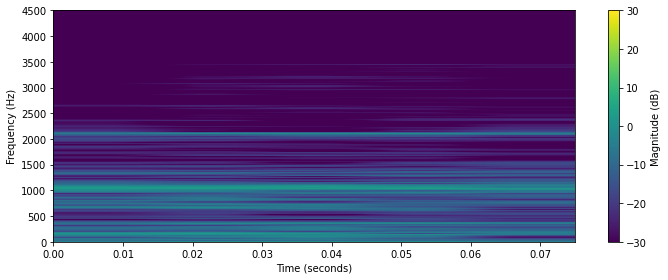

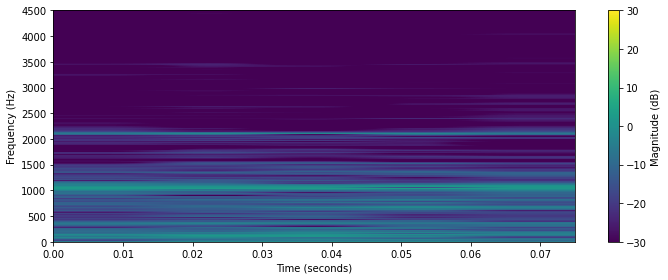

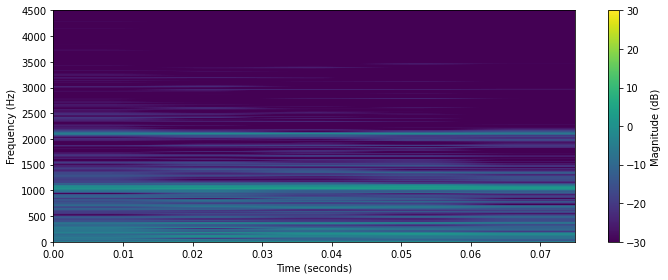

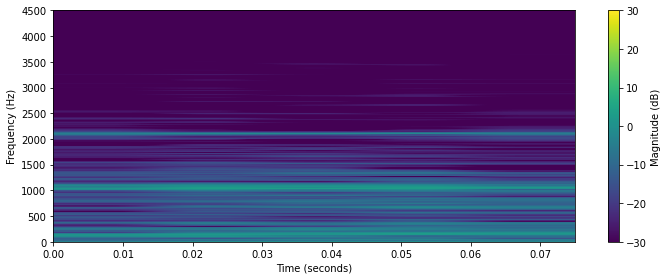

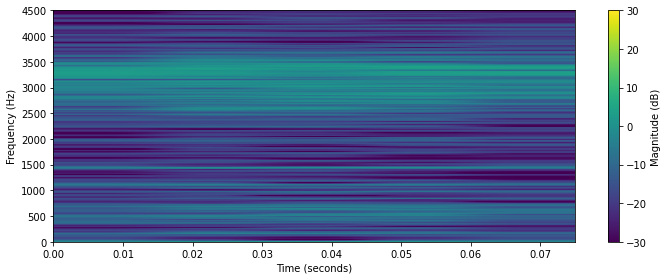

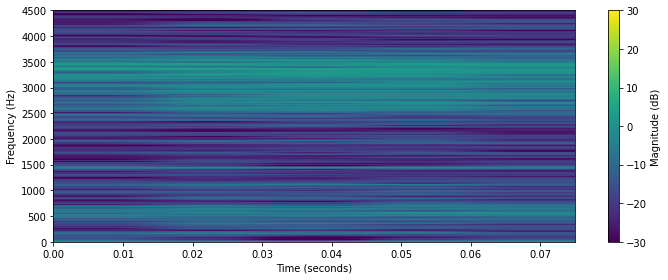

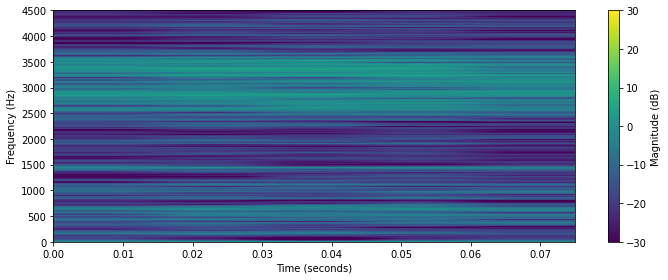

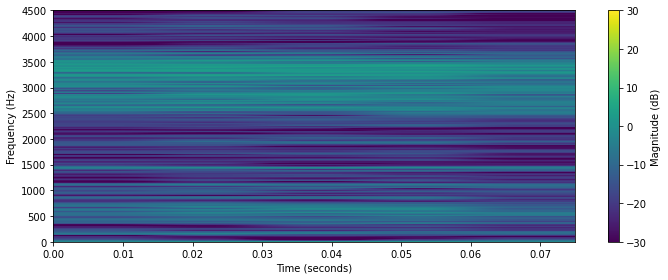

In [127]:
list_of_data_types = [G_data_N_DE_DATASET_A, G_data_faulty_DATASET_A]

for i in range(len(list_of_data_types)):

    print(f"input data shape", list_of_data_types[i].shape)
    sig = list_of_data_types[i]
    sig = np.reshape(sig, (sig.shape[1], sig.shape[0]))
    print(f"After reshape input data shape", sig.shape)

    samples = sig.shape[0]
    w_len = 900
    Hopesize = 255
    Fs = 12000
    
    for l in range(samples):
        Y, T_coef, F_coef = stft_window(sig[l], w_len, Fs, Hopesize)

        # Plot spectrogram
        if l <= 3:
           print("Shape of spectrogram", Y.shape)
           fig = plt.figure(figsize=(10, 4))
           eps = np.finfo(float).eps
           plt.imshow(10 * np.log10(eps + Y), origin='lower', aspect='auto', cmap='viridis', 
                      extent=[T_coef[0], T_coef[-1], F_coef[0], F_coef[-1]])
           plt.clim([-30, 30])
           plt.ylim([0, 4500])
           plt.xlabel('Time (seconds)')
           plt.ylabel('Frequency (Hz)')
           cbar = plt.colorbar()
           cbar.set_label('Magnitude (dB)')
           plt.tight_layout()
        
        sxx = 10 * np.log10(eps + Y)  
        image_shape = (224, 224)
        sxx = resize(sxx, image_shape, mode='constant', anti_aliasing=True)


del list_of_data_types

In [130]:
def loopOver_SignalSegmentsOf900_Spectrogram(typeOfBearingFault):
    
    # print(f"input data shape", typeOfBearingFault.shape)
    sig = typeOfBearingFault
    sig = np.reshape(sig, (sig.shape[1], sig.shape[0]))
    #print(f"After reshape input data shape", sig.shape)

    samples = sig.shape[0]
    w_len = 900
    Hopesize = 225
    Fs = 12000

    store = []
    for l in range(samples):
        Y, T_coef, F_coef = stft_window(sig[l], w_len, Fs, Hopesize)
        scaled_spc_images = 10 * np.log10(eps + Y)
        image_shape = (224, 224)
        Square_spectrograme_images = resize(scaled_spc_images, image_shape, mode='constant', anti_aliasing=True)
        arr = min_max_norm(Square_spectrograme_images) # array to 0 - 1
        store.append(arr)

    store = np.array(store)

    return store

In [131]:
G_data_N_DE_DATASET_A      = loopOver_SignalSegmentsOf900_Spectrogram(G_data_N_DE_DATASET_A)
G_data_faulty_DATASET_A = loopOver_SignalSegmentsOf900_Spectrogram(G_data_faulty_DATASET_A)

# G_data_N_DE_1      = loopOver_SignalSegmentsOf5s_Spectrogram(G_data_N_DE_1)
G_data_B_DE_DATASET_A = loopOver_SignalSegmentsOf900_Spectrogram(G_data_B_DE_DATASET_A)
G_data_IR_DE_DATASET_A = loopOver_SignalSegmentsOf900_Spectrogram(G_data_IR_DE_DATASET_A)
G_data_OR_DE_DATASET_A = loopOver_SignalSegmentsOf900_Spectrogram(G_data_OR_DE_DATASET_A)

# G_data_N_DE_1      = loopOver_SignalSegmentsOf5s_Spectrogram(G_data_N_DE_1)
G_data_B_007_DE_DATASET_A  = loopOver_SignalSegmentsOf900_Spectrogram(G_data_B_007_DE_DATASET_A)
G_data_B_014_DE_DATASET_A  = loopOver_SignalSegmentsOf900_Spectrogram(G_data_B_014_DE_DATASET_A)
G_data_B_021_DE_DATASET_A  = loopOver_SignalSegmentsOf900_Spectrogram(G_data_B_021_DE_DATASET_A)

G_data_IR_007_DE_DATASET_A = loopOver_SignalSegmentsOf900_Spectrogram(G_data_IR_007_DE_DATASET_A)
G_data_IR_014_DE_DATASET_A = loopOver_SignalSegmentsOf900_Spectrogram(G_data_IR_014_DE_DATASET_A)
G_data_IR_021_DE_DATASET_A = loopOver_SignalSegmentsOf900_Spectrogram(G_data_IR_021_DE_DATASET_A)

G_data_OR_007_DE_DATASET_A = loopOver_SignalSegmentsOf900_Spectrogram(G_data_OR_007_DE_DATASET_A)
G_data_OR_014_DE_DATASET_A = loopOver_SignalSegmentsOf900_Spectrogram(G_data_OR_014_DE_DATASET_A)
G_data_OR_021_DE_DATASET_A = loopOver_SignalSegmentsOf900_Spectrogram(G_data_OR_021_DE_DATASET_A)

In [132]:
print(G_data_N_DE_DATASET_A.shape)
print(G_data_faulty_DATASET_A.shape)

# G_data_N_DE_1   
print(G_data_B_DE_DATASET_A.shape)
print(G_data_IR_DE_DATASET_A.shape)
print(G_data_OR_DE_DATASET_A.shape)


# G_data_N_DE_1  
print(G_data_B_007_DE_DATASET_A.shape)  
print(G_data_B_014_DE_DATASET_A.shape)  
print(G_data_B_021_DE_DATASET_A.shape)  

print(G_data_IR_007_DE_DATASET_A.shape) 
print(G_data_IR_014_DE_DATASET_A.shape) 
print(G_data_IR_021_DE_DATASET_A.shape) 

print(G_data_OR_007_DE_DATASET_A.shape) 
print(G_data_OR_014_DE_DATASET_A.shape)
print(G_data_OR_021_DE_DATASET_A.shape) 

(271, 224, 224)
(1762, 224, 224)
(407, 224, 224)
(405, 224, 224)
(949, 224, 224)
(136, 224, 224)
(135, 224, 224)
(135, 224, 224)
(134, 224, 224)
(135, 224, 224)
(135, 224, 224)
(407, 224, 224)
(135, 224, 224)
(406, 224, 224)


### 4.4 Using k-fold cross-validation for evaluating a model’s performance

Separating 80%-20% for Train-Test

- `Train-Validation using K-Fold Cross Validation`

- Normal (Not Faulty) - 80% Train

- Ball Fault Location - 80% Train

- Inner Race Fault Location - 80% Train

- Outer Race Fault Location - 80% Train

----------------------------

- `Allocate 20% of the bearing fault dataset for final test`

- Normal (Not Faulty) - 20% Test

- Ball Fault Location - 20% Test

- Inner Race Fault Location - 20% Test

- Outer Race Fault Location - 20% Test

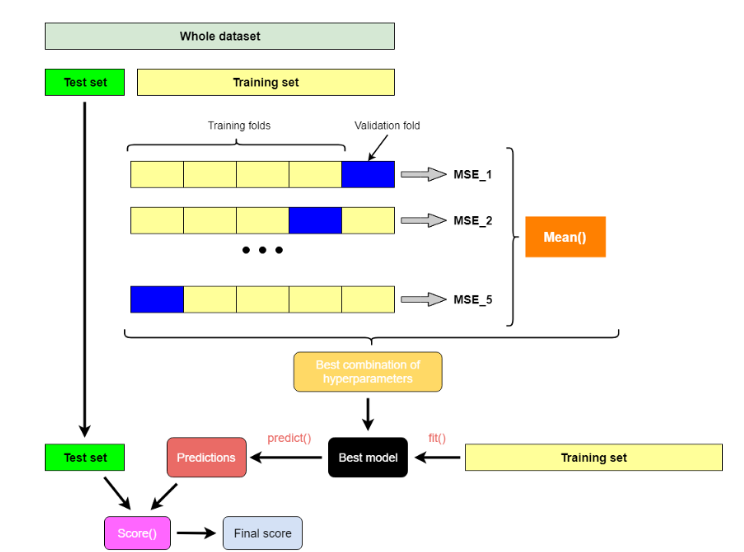

In [76]:

# Normal_data_train, Normal_data_test = Percent_data_split(G_data_N_DE_1, G_data_N_DE_1, percent_1 = 80, index_1 = False)
# Normal_data_train, Normal_data_valid = Percent_data_split(Normal_data_train, Normal_data_train, percent_1 = 50, index_1 = False)
# print('Original Nominal Data before slicing',G_data_N_DE.shape)
# print("Normal_data_train", Normal_data_train.shape)
# print("Normal_data_valid", Normal_data_valid.shape)
# print("Normal_data_test", Normal_data_test.shape)
# 
# Faulty_data_train, Faulty_data_test = Percent_data_split(G_data_faulty_DE_1, G_data_faulty_DE_1, percent_1 = 80, index_1 = False)
# Faulty_data_train, Faulty_data_valid = Percent_data_split(Faulty_data_train, Faulty_data_train, percent_1 = 50, index_1 = False)
# print('Original Faulty Data before slicing',G_data_faulty.shape)
# print("Faulty_data_train", Faulty_data_train.shape)
# print("Faulty_data_valid", Faulty_data_valid.shape)
# print("Faulty_data_test", Faulty_data_test.shape)

In [77]:

# Normal_data_train, Normal_data_test = Percent_data_split(G_data_N_DE_1, G_data_N_DE_1, percent_1 = 80, index_1 = False)
# Normal_data_train, Normal_data_valid = Percent_data_split(Normal_data_train, Normal_data_train, percent_1 = 50, index_1 = False)
# print('Original Nominal Data before slicing',G_data_N_DE.shape)
# print("Normal_data_train", Normal_data_train.shape)
# print("Normal_data_valid", Normal_data_valid.shape)
# print("Normal_data_test", Normal_data_test.shape)
# 
# Ball_data_train, Ball_data_test = Percent_data_split(G_data_B_DE_1, G_data_B_DE_1, percent_1 = 80, index_1 = False)
# Ball_data_train, Ball_data_valid = Percent_data_split(Ball_data_train, Ball_data_train, percent_1 = 50, index_1 = False)
# print('Original Ball bearing faulty Data before slicing', G_data_B_DE.shape)
# print("Ball_data_train", Ball_data_train.shape)
# print("Ball_data_valid", Ball_data_valid.shape)
# print("Ball_data_test", Ball_data_test.shape)
# 
# IR_data_train, IR_data_test =  Percent_data_split(G_data_IR_DE_1, G_data_IR_DE_1, percent_1 = 80, index_1 = False)
# IR_data_train, IR_data_valid =  Percent_data_split(IR_data_train, IR_data_train, percent_1 = 50, index_1 = False)
# print('Original Inner race fault Data before slicing', G_data_IR_DE.shape)
# print("IR_data_train", IR_data_train.shape)
# print("IR_data_valid", IR_data_valid.shape)
# print("IR_data_test", IR_data_test.shape)
# 
# OR_data_train, OR_data_test =  Percent_data_split(G_data_OR_DE_1, G_data_OR_DE_1, percent_1 = 80, index_1 = False)
# OR_data_train, OR_data_valid =  Percent_data_split(OR_data_train, OR_data_train, percent_1 = 50, index_1 = False)
# print('Original Outer race fault Data before slicing', G_data_OR_DE.shape)
# print("OR_data_train", OR_data_train.shape)
# print("OR_data_valid", OR_data_valid.shape)
# print("OR_data_test", OR_data_test.shape)

In [133]:
Normal_data_train, Normal_data_test = Percent_data_split(G_data_N_DE_DATASET_A, G_data_N_DE_DATASET_A, percent_1 = 80, index_1 = False)
Normal_data_train, Normal_data_valid = Percent_data_split(Normal_data_train, Normal_data_train, percent_1 = 50, index_1 = False)
print('Original Nominal Data before slicing',G_data_N_DE_DATASET_A.shape)
print("Normal_data_train", Normal_data_train.shape)
print("Normal_data_valid", Normal_data_valid.shape)
print("Normal_data_test", Normal_data_test.shape)

Ball_data_train_007, Ball_data_test_007 = Percent_data_split(G_data_B_007_DE_DATASET_A, G_data_B_007_DE_DATASET_A, percent_1 = 80, index_1 = False)
Ball_data_train_007, Ball_data_valid_007 = Percent_data_split(Ball_data_train_007, Ball_data_train_007, percent_1 = 50, index_1 = False)
print('Original Ball bearing fault diameter 007 Data before slicing', G_data_B_007_DE_DATASET_A.shape)
print("Ball_data_train_007", Ball_data_train_007.shape)
print("Ball_data_valid_007", Ball_data_valid_007.shape)
print("Ball_data_test_007", Ball_data_test_007.shape)

Ball_data_train_014, Ball_data_test_014 = Percent_data_split(G_data_B_014_DE_DATASET_A, G_data_B_014_DE_DATASET_A, percent_1 = 80, index_1 = False)
Ball_data_train_014, Ball_data_valid_014 = Percent_data_split(Ball_data_train_014, Ball_data_train_014, percent_1 = 50, index_1 = False)
print('Original Ball bearing fault diameter 014 Data before slicing', G_data_B_014_DE.shape)
print("Ball_data_trai_014n", Ball_data_train_014.shape)
print("Ball_data_valid_014", Ball_data_valid_014.shape)
print("Ball_data_test_014", Ball_data_test_014.shape)

Ball_data_train_021, Ball_data_test_021 = Percent_data_split(G_data_B_021_DE_DATASET_A, G_data_B_021_DE_DATASET_A, percent_1 = 80, index_1 = False)
Ball_data_train_021, Ball_data_valid_021 = Percent_data_split(Ball_data_train_021, Ball_data_train_021, percent_1 = 50, index_1 = False)
print('Original Ball bearing fault diameter 021 Data before slicing', G_data_B_021_DE_DATASET_A.shape)
print("Ball_data_train_021", Ball_data_train_021.shape)
print("Ball_data_valid_021", Ball_data_valid_021.shape)
print("Ball_data_test_021", Ball_data_test_021.shape)

IR_data_train_007, IR_data_test_007 =  Percent_data_split(G_data_IR_007_DE_DATASET_A, G_data_IR_007_DE_DATASET_A, percent_1 = 80, index_1 = False)
IR_data_train_007, IR_data_valid_007 =  Percent_data_split(IR_data_train_007, IR_data_train_007, percent_1 = 50, index_1 = False)
print('Original Inner race fault diameter 007 Data before slicing', G_data_IR_007_DE_DATASET_A.shape)
print("IR_data_train_007", IR_data_train_007.shape)
print("IR_data_valid_007", IR_data_valid_007.shape)
print("IR_data_test_007", IR_data_test_007.shape)

IR_data_train_014, IR_data_test_014 =  Percent_data_split(G_data_IR_014_DE_DATASET_A, G_data_IR_014_DE_DATASET_A, percent_1 = 80, index_1 = False)
IR_data_train_014, IR_data_valid_014 =  Percent_data_split(IR_data_train_014, IR_data_train_014, percent_1 = 50, index_1 = False)
print('Original Inner race fault diameter 014 Data before slicing', G_data_IR_014_DE_DATASET_A.shape)
print("IR_data_train_014", IR_data_train_014.shape)
print("IR_data_valid_014", IR_data_valid_014.shape)
print("IR_data_test_014", IR_data_test_014.shape)

IR_data_train_021, IR_data_test_021 =  Percent_data_split(G_data_IR_021_DE_DATASET_A, G_data_IR_021_DE_DATASET_A, percent_1 = 80, index_1 = False)
IR_data_train_021, IR_data_valid_021 =  Percent_data_split(IR_data_train_021, IR_data_train_021, percent_1 = 50, index_1 = False)
print('Original Inner race fault diameter 021 Data before slicing', G_data_IR_021_DE_DATASET_A.shape)
print("IR_data_train_021", IR_data_train_021.shape)
print("IR_data_valid_021", IR_data_valid_021.shape)
print("IR_data_test_021", IR_data_test_021.shape)

OR_data_train_007, OR_data_test_007 =  Percent_data_split(G_data_OR_007_DE_DATASET_A, G_data_OR_007_DE_DATASET_A, percent_1 = 80, index_1 = False)
OR_data_train_007, OR_data_valid_007 =  Percent_data_split(OR_data_train_007, OR_data_train_007, percent_1 = 50, index_1 = False)
print('Original Outer race fault diameter 007 Data before slicing', G_data_OR_007_DE_DATASET_A.shape)
print("OR_data_train_007", OR_data_train_007.shape)
print("OR_data_valid_007", OR_data_valid_007.shape)
print("OR_data_test_007", OR_data_test_007.shape)
 
OR_data_train_014, OR_data_test_014 =  Percent_data_split(G_data_OR_014_DE_DATASET_A, G_data_OR_014_DE_DATASET_A, percent_1 = 80, index_1 = False)
OR_data_train_014, OR_data_valid_014 =  Percent_data_split(OR_data_train_014, OR_data_train_014, percent_1 = 50, index_1 = False)
print('Original Outer race fault diameter 014 Data before slicing', G_data_OR_014_DE_DATASET_A.shape)
print("OR_data_train_014", OR_data_train_014.shape)
print("OR_data_valid_014", OR_data_valid_014.shape)
print("OR_data_test_014", OR_data_test_014.shape)

OR_data_train_021, OR_data_test_021 =  Percent_data_split(G_data_OR_021_DE_DATASET_A, G_data_OR_021_DE_DATASET_A, percent_1 = 80, index_1 = False)
OR_data_train_021, OR_data_valid_021 =  Percent_data_split(OR_data_train_021, OR_data_train_021, percent_1 = 50, index_1 = False)
print('Original Outer race fault diameter 021 Data before slicing', G_data_OR_021_DE_DATASET_A.shape)
print("OR_data_train_021", OR_data_train_021.shape)
print("OR_data_valid_021", OR_data_valid_021.shape)
print("OR_data_test_021", OR_data_test_021.shape)

Original Nominal Data before slicing (271, 224, 224)
Normal_data_train (108, 224, 224)
Normal_data_valid (108, 224, 224)
Normal_data_test (55, 224, 224)
Original Ball bearing fault diameter 007 Data before slicing (136, 224, 224)
Ball_data_train_007 (54, 224, 224)
Ball_data_valid_007 (54, 224, 224)
Ball_data_test_007 (28, 224, 224)
Original Ball bearing fault diameter 014 Data before slicing (122136,)
Ball_data_trai_014n (54, 224, 224)
Ball_data_valid_014 (54, 224, 224)
Ball_data_test_014 (27, 224, 224)
Original Ball bearing fault diameter 021 Data before slicing (135, 224, 224)
Ball_data_train_021 (54, 224, 224)
Ball_data_valid_021 (54, 224, 224)
Ball_data_test_021 (27, 224, 224)
Original Inner race fault diameter 007 Data before slicing (134, 224, 224)
IR_data_train_007 (53, 224, 224)
IR_data_valid_007 (54, 224, 224)
IR_data_test_007 (27, 224, 224)
Original Inner race fault diameter 014 Data before slicing (135, 224, 224)
IR_data_train_014 (54, 224, 224)
IR_data_valid_014 (54, 224, 2

In [134]:
def store_sp_images(list_of_items):
    print(f"name of data passed {namestr(list_of_items, globals())} and shape {list_of_items.shape}")
    store = []
    for i in range(len(list_of_items[:,0])):
        i = list_of_items[i]
        i = np.array(i)
        # print(i.shape)
        i = i[:, :, np.newaxis]
        i = np.repeat(i, repeats = 3, axis = -1)
        store.append(i)

    return np.array(store)


In [135]:
del G_data_N_DE_DATASET_A, G_data_faulty_DATASET_A, G_data_B_DE_DATASET_A, G_data_IR_DE_DATASET_A
del G_data_OR_DE_DATASET_A, G_data_B_007_DE_DATASET_A, G_data_B_014_DE_DATASET_A, G_data_B_021_DE_DATASET_A
del G_data_IR_007_DE_DATASET_A, G_data_IR_014_DE_DATASET_A, G_data_IR_021_DE_DATASET_A
del G_data_OR_007_DE_DATASET_A, G_data_OR_014_DE_DATASET_A, G_data_OR_021_DE_DATASET_A

In [81]:
# Normal_train = store_sp_images(Normal_data_train)
# Normal_valid = store_sp_images(Normal_data_valid)
# Normal_test  = store_sp_images(Normal_data_test)
# 
# Faulty_train = store_sp_images(Faulty_data_train)
# Faulty_valid = store_sp_images(Faulty_data_valid)
# Faulty_test  = store_sp_images(Faulty_data_test)

In [82]:
# Normal_train = store_sp_images(Normal_data_train)
# Normal_valid = store_sp_images(Normal_data_valid)
# Normal_test  = store_sp_images(Normal_data_test)
# 
# Ball_train   = store_sp_images(Ball_data_train)
# Ball_valid   = store_sp_images(Ball_data_valid)
# Ball_test    = store_sp_images(Ball_data_test)
# 
# IR_train     = store_sp_images(IR_data_train)
# IR_valid     = store_sp_images(IR_data_valid)
# IR_test      = store_sp_images(IR_data_test)
# 
# OR_train     = store_sp_images(OR_data_train)
# OR_valid     = store_sp_images(OR_data_valid)
# OR_test      = store_sp_images(OR_data_test)

In [136]:
Normal_train   =   store_sp_images(np.array(Normal_data_train))
Normal_valid   =   store_sp_images(np.array(Normal_data_valid))
Normal_test    =    store_sp_images(np.array(Normal_data_test))

Ball_train_007 = store_sp_images(np.array(Ball_data_train_007))
Ball_valid_007 = store_sp_images(np.array(Ball_data_valid_007))
Ball_test_007  =  store_sp_images(np.array(Ball_data_test_007))

Ball_train_014 = store_sp_images(np.array(Ball_data_train_014))
Ball_valid_014 = store_sp_images(np.array(Ball_data_valid_014))
Ball_test_014  =  store_sp_images(np.array(Ball_data_test_014))

Ball_train_021 = store_sp_images(np.array(Ball_data_train_021))
Ball_valid_021 = store_sp_images(np.array(Ball_data_valid_021))
Ball_test_021  =  store_sp_images(np.array(Ball_data_test_021))

IR_train_007   =   store_sp_images(np.array(IR_data_train_007))
IR_valid_007   =   store_sp_images(np.array(IR_data_valid_007))
IR_test_007    =    store_sp_images(np.array(IR_data_test_007))
    
IR_train_014   =   store_sp_images(np.array(IR_data_train_014))
IR_valid_014   =   store_sp_images(np.array(IR_data_valid_014))
IR_test_014    =    store_sp_images(np.array(IR_data_test_014))
    
IR_train_021   =   store_sp_images(np.array(IR_data_train_021))
IR_valid_021   =   store_sp_images(np.array(IR_data_valid_021))
IR_test_021    =    store_sp_images(np.array(IR_data_test_021))
  
OR_train_007   =   store_sp_images(np.array(OR_data_train_007))
OR_valid_007   =   store_sp_images(np.array(OR_data_valid_007))
OR_test_007    =    store_sp_images(np.array(OR_data_test_007))
  
OR_train_014    =   store_sp_images(np.array(OR_data_train_014))
OR_valid_014    =   store_sp_images(np.array(OR_data_valid_014))
OR_test_014     =    store_sp_images(np.array(OR_data_test_014))
    
OR_train_021    =   store_sp_images(np.array(OR_data_train_021))
OR_valid_021    =   store_sp_images(np.array(OR_data_valid_021))
OR_test_021     =    store_sp_images(np.array(OR_data_test_021))

name of data passed [] and shape (108, 224, 224)
name of data passed [] and shape (108, 224, 224)
name of data passed [] and shape (55, 224, 224)
name of data passed [] and shape (54, 224, 224)
name of data passed [] and shape (54, 224, 224)
name of data passed [] and shape (28, 224, 224)
name of data passed [] and shape (54, 224, 224)
name of data passed [] and shape (54, 224, 224)
name of data passed [] and shape (27, 224, 224)
name of data passed [] and shape (54, 224, 224)
name of data passed [] and shape (54, 224, 224)
name of data passed [] and shape (27, 224, 224)
name of data passed [] and shape (53, 224, 224)
name of data passed [] and shape (54, 224, 224)
name of data passed [] and shape (27, 224, 224)
name of data passed [] and shape (54, 224, 224)
name of data passed [] and shape (54, 224, 224)
name of data passed [] and shape (27, 224, 224)
name of data passed [] and shape (54, 224, 224)
name of data passed [] and shape (54, 224, 224)
name of data passed [] and shape (27, 

## 4.4 Preparing Train-Test Data

### 4.4.1 Image loading

Now to define a function that loads the images that were generated.

With the aid of the previous function the images for DE and `TRAIN` is loaded. 

With the aid of the previous function, the images for DE and `VALIDATION` are loaded.

With the aid of the previous function, the images for DE and `TEST` are loaded.

In [137]:
def give_image_a_label(images, label):
    storage = []
    for i in range(images.shape[0]):
        storage.append(label)

    return np.array(storage).astype(np.float32)

In [85]:
# Normal_train_y =  give_image_a_label(Normal_data_train, 0)
# Normal_valid_y =  give_image_a_label(Normal_data_valid, 0)
# Normal_test_y  =  give_image_a_label(Normal_data_test, 0)
# 
# Faulty_train_y =  give_image_a_label(Faulty_data_train, 1)
# Faulty_valid_y =  give_image_a_label(Faulty_data_valid, 1)
# Faulty_test_y  =  give_image_a_label(Faulty_data_test, 1)

In [86]:
# Normal_train_y =  give_image_a_label(Normal_train, 0)
# Normal_valid_y =  give_image_a_label(Normal_valid, 0)
# Normal_test_y  =  give_image_a_label(Normal_test, 0)
# 
# Ball_train_y =  give_image_a_label(Ball_train, 1)
# Ball_valid_y =  give_image_a_label(Ball_valid, 1)
# Ball_test_y  =  give_image_a_label(Ball_test, 1)
# 
# IR_train_y =  give_image_a_label(IR_train, 2)
# IR_valid_y =  give_image_a_label(IR_valid, 2)
# IR_test_y  =  give_image_a_label(IR_test, 2)
# 
# OR_train_y =  give_image_a_label(OR_train, 3)
# OR_valid_y =  give_image_a_label(OR_valid, 3)
# OR_test_y  =  give_image_a_label(OR_test, 3)

In [138]:
Normal_train_y =  give_image_a_label(Normal_train, 0)
Normal_valid_y =  give_image_a_label(Normal_valid, 0)
Normal_test_y  =  give_image_a_label(Normal_test, 0)

Ball_train_007_y = give_image_a_label(Ball_train_007, 1)
Ball_valid_007_y = give_image_a_label(Ball_valid_007, 1)
Ball_test_007_y =  give_image_a_label(Ball_test_007, 1)

Ball_train_014_y = give_image_a_label(Ball_train_014, 2)
Ball_valid_014_y = give_image_a_label(Ball_valid_014, 2)
Ball_test_014_y  =  give_image_a_label(Ball_test_014, 2)

Ball_train_021_y = give_image_a_label(Ball_train_021, 3)
Ball_valid_021_y = give_image_a_label(Ball_valid_021, 3)
Ball_test_021_y  =  give_image_a_label(Ball_test_021, 3)

IR_train_007_y = give_image_a_label(IR_train_007, 4)
IR_valid_007_y = give_image_a_label(IR_valid_007, 4)
IR_test_007_y  =  give_image_a_label(IR_test_007, 4)

IR_train_014_y = give_image_a_label(IR_train_014, 5)
IR_valid_014_y = give_image_a_label(IR_valid_014, 5)
IR_test_014_y  =  give_image_a_label(IR_test_014, 5)

IR_train_021_y = give_image_a_label(IR_train_021, 6)
IR_valid_021_y = give_image_a_label(IR_valid_021, 6)
IR_test_021_y  =  give_image_a_label(IR_test_021, 6)

OR_train_007_y = give_image_a_label(OR_train_007, 7)
OR_valid_007_y = give_image_a_label(OR_valid_007, 7)
OR_test_007_y  =  give_image_a_label(OR_test_007, 7)

OR_train_014_y = give_image_a_label(OR_train_014, 8)
OR_valid_014_y = give_image_a_label(OR_valid_014, 8)
OR_test_014_y  =  give_image_a_label(OR_test_014, 8)

OR_train_021_y = give_image_a_label(OR_train_021, 9)
OR_valid_021_y = give_image_a_label(OR_valid_021, 9)
OR_test_021_y  =  give_image_a_label(OR_test_021, 9)

In [88]:
# y_train = np.concatenate((Normal_train_y, Faulty_train_y), axis=0)
# 
# y_valid = np.concatenate((Normal_valid_y, Faulty_valid_y), axis=0)
# 
# y_test = np.concatenate((Normal_test_y, Faulty_test_y), axis=0)
# 
# print(y_train.shape)
# print(y_valid.shape)
# print(y_test.shape)

In [89]:
# y_train = np.concatenate((Normal_train_y, Ball_train_y, IR_train_y, OR_train_y), axis=0)
# 
# y_valid = np.concatenate((Normal_valid_y, Ball_valid_y, IR_valid_y, OR_valid_y), axis=0)
# 
# y_test = np.concatenate((Normal_test_y, Ball_test_y, IR_test_y, OR_test_y), axis=0)
# 
# print(y_train.shape)
# print(y_valid.shape)
# print(y_test.shape)

In [139]:
y_train = np.concatenate((Normal_train_y, Ball_train_007_y, Ball_train_014_y, Ball_train_021_y,
                                          IR_train_007_y, IR_train_014_y, IR_train_021_y,
                                          OR_train_007_y, OR_train_014_y, OR_train_021_y), axis=0)

y_valid = np.concatenate((Normal_valid_y, Ball_valid_007_y, Ball_valid_014_y, Ball_valid_021_y,
                                          IR_valid_007_y, IR_valid_014_y, IR_valid_021_y,
                                          OR_valid_007_y, OR_valid_014_y, OR_valid_021_y), axis=0)

y_test = np.concatenate((Normal_test_y, Ball_test_007_y, Ball_test_014_y, Ball_test_021_y,
                                        IR_test_007_y, IR_test_014_y, IR_test_021_y,
                                        OR_test_007_y, OR_test_014_y, OR_test_021_y), axis=0)

print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(809,)
(811,)
(409,)


In [91]:
# X_train = np.concatenate((Normal_train, Faulty_train), axis=0)
# 
# X_valid = np.concatenate((Normal_valid, Faulty_valid), axis=0)
# 
# X_test = np.concatenate((Normal_test, Faulty_test), axis=0)
# 
# print(X_train.shape)
# print(X_valid.shape)
# print(X_test.shape)

In [92]:
# X_train = np.concatenate((Normal_train, Ball_train, IR_train, OR_train), axis=0)
# 
# X_valid = np.concatenate((Normal_valid, Ball_valid, IR_valid, OR_valid), axis=0)
# 
# X_test = np.concatenate((Normal_test, Ball_test, IR_test, OR_test), axis=0)
# 
# print(X_train.shape)
# print(X_valid.shape)
# print(X_test.shape)

In [140]:
X_train = np.concatenate((Normal_train, Ball_train_007, Ball_train_014, Ball_train_021, IR_train_007, IR_train_014, IR_train_021, OR_train_007,  OR_train_014,  OR_train_021), axis=0)

X_valid = np.concatenate((Normal_valid, Ball_valid_007, Ball_valid_014, Ball_valid_021, IR_valid_007, IR_valid_014, IR_valid_021, OR_valid_007,  OR_valid_014,  OR_valid_021), axis=0)

X_test =   np.concatenate((Normal_test, Ball_test_007,  Ball_test_014,  Ball_test_021,  IR_test_007,  IR_test_014,  IR_test_021,  OR_test_007,   OR_test_014,   OR_test_021), axis=0)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(809, 224, 224, 3)
(811, 224, 224, 3)
(409, 224, 224, 3)


In [141]:
from torch.utils.data import Dataset, TensorDataset, DataLoader
class CustomTensorDataset(Dataset):
    """ TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  
  image = image.transpose(1, 2, 0)
  image = image.clip(0, 1)
  return image

In [142]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_valid = torch.tensor(X_valid, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(np.array(y_train).astype(np.float32)).type(torch.LongTensor)
y_valid = torch.tensor(np.array(y_valid).astype(np.float32)).type(torch.LongTensor)
y_test = torch.tensor(np.array(y_test).astype(np.float32)).type(torch.LongTensor)

In [143]:
X_train = X_train.permute(0, 3, 1, 2)
X_valid = X_valid.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [144]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

torch.Size([809, 3, 224, 224])
torch.Size([811, 3, 224, 224])
torch.Size([409, 3, 224, 224])


In [145]:
train_ds = CustomTensorDataset(tensors =  (X_train, y_train))
valid_ds = CustomTensorDataset(tensors =  (X_valid, y_valid))
test_ds = CustomTensorDataset(tensors  =  (X_test, y_test))

In [146]:
image_datasets = {}
image_datasets['train'] = train_ds
image_datasets['valid'] = valid_ds
image_datasets['test']  = test_ds

dataloaders = {'train': DataLoader(image_datasets['train'], batch_size=16, shuffle=True),
               'valid': DataLoader(image_datasets['valid'], batch_size=16, shuffle=True),
               'test': DataLoader(image_datasets['test'], batch_size=16, shuffle=True)
              } 

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
class_names = classes

### If all images are Dark, please don't worry, because plt.imshow doesn't display spectrogram correctly, but the images are exactly like the ones on top

torch.Size([16, 3, 224, 224])


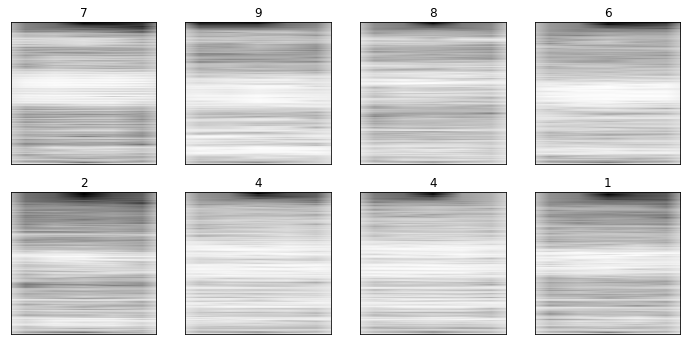

In [147]:
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()
print(images.shape)
fig = plt.figure(figsize=(12, 12))
 
for idx in np.arange(8):
  ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]), origin='lower', aspect='auto')
  ax.set_title(classes[labels[idx].item()])

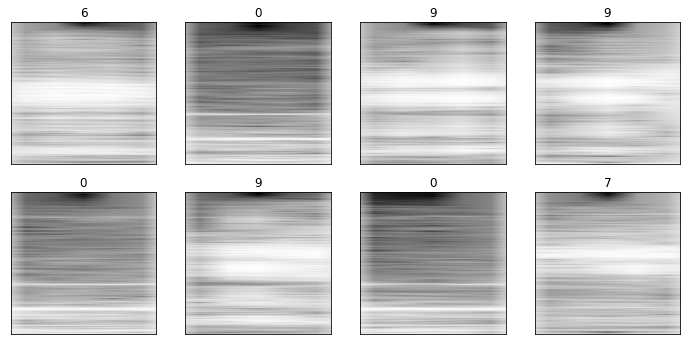

In [148]:
dataiter = iter(dataloaders['valid'])
images, labels = dataiter.next()
fig = plt.figure(figsize=(12, 12))
 
for idx in np.arange(8):
  ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]), origin='lower', aspect='auto')
  ax.set_title(classes[labels[idx].item()])

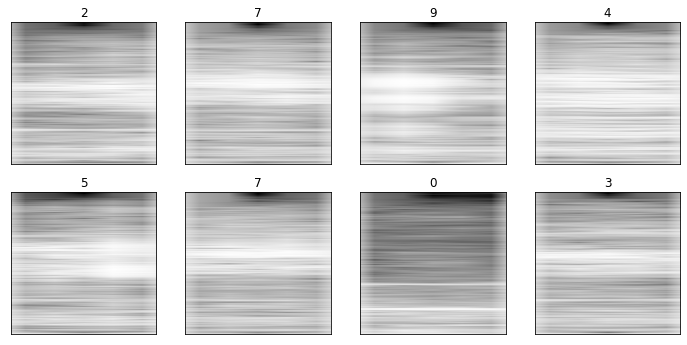

In [149]:
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()
fig = plt.figure(figsize=(12, 12))
 
for idx in np.arange(8):
  ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]), origin='lower', aspect='auto')
  ax.set_title(classes[labels[idx].item()])

## Convolutional Neural Network
The CNN architecture used in this notebook is from the paper Deep Learning Enabled Fault Diagnosis Using Time-Frequency Image Analysis of Rolling Element Bearings. It is a proposed architecture. This architecture is used due to the resolution of the image and it yields very good results in terms of precision.

## CNN model with Pytorch
It is a supervised classification problem, with 10 classes. A Convolutional Neural Network (CNN) is implemented as a pytorch model.

The loss function is categorical cross-entropy, the optimizer is ADAM and Leaky RELU is the activation function used after each Convolution layer. The learning rate has been tested to different values and in the end learning rate decay was followed manually for that matter.

In [150]:
# Model instantiation, Pretrained weights and biases
model_resnet18 = models.resnet18(weights=True)
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, 10)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_resnet18 = model_resnet18.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [152]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MultiLabelBinarizer
from itertools import cycle

torch.manual_seed(42)

criterion = nn.CrossEntropyLoss()

dataset = ConcatDataset([train_ds, valid_ds])

num_epochs=100
batch_size=64
k=5

splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}

In [153]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct, model
  
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct, model

In [ ]:
import copy
best_model = None
best_accuracy = -1
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    

    num_ftrs = model_resnet18.fc.in_features
    model_resnet18.fc = nn.Linear(num_ftrs, 10)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = model_resnet18.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9,0.999), weight_decay=1e-2)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct, model = train_epoch(model,device,train_loader,criterion,optimizer)
        test_loss, test_correct, model = valid_epoch(model,device,test_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} "
         "AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,num_epochs,train_loss,test_loss,train_acc,test_acc))

        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history

    #save best model
    accuracy =  np.array(history['test_acc']).max()
    if (accuracy > best_accuracy).all():
      
       # path to save models to:
       path = '/content/Saved_models'
       best_model = copy.deepcopy(model)
       model_saved = torch.save(best_model.state_dict(), path + ' best-model.pt')

    
    
    del model
    del optimizer  


Fold 1
Epoch:1/100 AVG Training Loss:0.929 AVG Test Loss:2.255 AVG Training Acc 75.31 % AVG Test Acc 38.58 %
Epoch:2/100 AVG Training Loss:0.063 AVG Test Loss:0.491 AVG Training Acc 99.69 % AVG Test Acc 83.02 %
Epoch:3/100 AVG Training Loss:0.013 AVG Test Loss:0.054 AVG Training Acc 100.00 % AVG Test Acc 99.38 %
Epoch:4/100 AVG Training Loss:0.008 AVG Test Loss:0.016 AVG Training Acc 100.00 % AVG Test Acc 99.69 %
Epoch:5/100 AVG Training Loss:0.006 AVG Test Loss:0.010 AVG Training Acc 100.00 % AVG Test Acc 100.00 %
Epoch:6/100 AVG Training Loss:0.006 AVG Test Loss:0.010 AVG Training Acc 100.00 % AVG Test Acc 100.00 %
Epoch:7/100 AVG Training Loss:0.006 AVG Test Loss:0.009 AVG Training Acc 100.00 % AVG Test Acc 100.00 %
Epoch:8/100 AVG Training Loss:0.004 AVG Test Loss:0.008 AVG Training Acc 100.00 % AVG Test Acc 100.00 %
Epoch:9/100 AVG Training Loss:0.004 AVG Test Loss:0.007 AVG Training Acc 100.00 % AVG Test Acc 100.00 %
Epoch:10/100 AVG Training Loss:0.004 AVG Test Loss:0.008 AVG Tr

In [1]:
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=5
for f in range(1,k+1):

     tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
     testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

     ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
     testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))

NameError: ignored

In [ ]:
k=5
for f in range(1,k+1):
    tl_f = foldperf['fold{}'.format(f)]['train_loss']
    testl_f = foldperf['fold{}'.format(f)]['test_loss']
    plt.plot(tl_f)
    plt.plot(testl_f)
    plt.title(f'model loss of Fold: {f}')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
del tl_f, testl_f

In [ ]:
k=5
for f in range(1,k+1):
    ta_f = foldperf['fold{}'.format(f)]['train_acc']
    testa_f = foldperf['fold{}'.format(f)]['test_acc']
    plt.plot(ta_f)
    plt.plot(testa_f)
    plt.title(f'model acc of Fold: {f}')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## 5.9 Confusion matrix: 

In [ ]:
del zip
del ZipFile

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_resnet18 = models.resnet18(pretrained=True)
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, 10)
model = model_resnet18.to(device)

model.load_state_dict(torch.load('/content/Saved_models best-model.pt'))

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

nb_classes = 10

confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

# Normalise
cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12,12))

group_names = ('Nominal', 'Faulty')

group_counts = ["{0:.2f}".format(value) for value in
                cmn.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix.flatten()/np.sum(confusion_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(10,10)

class_names = ('Nominal', 'B_007', 'B_014', 'B_021', 'IR_007', 'IR_014', 'IR_021', 'OR_007', 'OR_014', 'OR_021')

ax = sns.heatmap(cmn, annot=labels, fmt='', cmap='Blues',  xticklabels=class_names, yticklabels=class_names)

ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=14)
ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=14)
plt.title('Confusion Matrix', fontsize=18)
plt.ylabel('True Label', fontsize=16)
plt.xlabel('Predicted Label', fontsize=16)

# class_names = ('Nominal', 'B_007', 'B_014', 'B_021', 'IR_007', 'IR_014', 'IR_021', 'OR_007', 'OR_014', 'OR_021')
# class_names = ('Nominal', 'B_B', 'B_IR','B_OR')
# group_names = ('Nominal', 'Faulty')

# 6. ROC analysis

The ROC curves for each class give a complete picture of the classification performance of the CNN. The function below performs this task.

## 6.1 ROC curve, Confusion matrix and accuracies

In [ ]:
import torch
import torch.nn as nn
import os
import numpy as np
from torchvision.datasets import ImageFolder
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score

num_class = 10  
gpu = "cuda:0"  


def test(model, dataloaders_name='test'):

    model.eval()

    score_list = []     
    label_list = []     
    for i, (inputs, labels) in enumerate(dataloaders[dataloaders_name]):
        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = model(inputs)
        
        score_tmp = outputs  

        score_list.extend(score_tmp.detach().cpu().numpy())
        label_list.extend(labels.cpu().numpy())

    score_array = np.array(score_list)
    # 将label转换成onehot形式
    label_tensor = torch.tensor(label_list)
    label_tensor = label_tensor.reshape((label_tensor.shape[0], 1))
    label_onehot = torch.zeros(label_tensor.shape[0], num_class)
    label_onehot.scatter_(dim=1, index=label_tensor, value=1)
    label_onehot = np.array(label_onehot)

    print("score_array:", score_array.shape)  # (batchsize, classnum)
    print("label_onehot:", label_onehot.shape)  # torch.Size([batchsize, classnum])

    # 调用sklearn库，计算每个类别对应的fpr和tpr
    fpr_dict = dict()
    tpr_dict = dict()
    roc_auc_dict = dict()
    for i in range(num_class):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(label_onehot[:, i], score_array[:, i])
        roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
    # micro
    fpr_dict["micro"], tpr_dict["micro"], _ = roc_curve(label_onehot.ravel(), score_array.ravel())
    roc_auc_dict["micro"] = auc(fpr_dict["micro"], tpr_dict["micro"])

    # macro
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(num_class)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_class):
        mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])
    # Finally average it and compute AUC
    mean_tpr /= num_class
    fpr_dict["macro"] = all_fpr
    tpr_dict["macro"] = mean_tpr
    roc_auc_dict["macro"] = auc(fpr_dict["macro"], tpr_dict["macro"])

    # 绘制所有类别平均的roc曲线
    plt.figure(figsize=(12,12))
    lw = 2
    plt.plot(fpr_dict["micro"], tpr_dict["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc_dict["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot(fpr_dict["macro"], tpr_dict["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc_dict["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['Black', 'Red', 'Green', 'Brown', 'Blue', 'Yellow', 'Purple', 'gray', 'aqua', 'pink'])
    for i, color in zip(range(num_class), colors):
        plt.plot(fpr_dict[i], tpr_dict[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(i, roc_auc_dict[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.savefig('set113_roc.jpg')
    plt.show()

In [ ]:
model.load_state_dict(torch.load('/content/Saved_models best-model.pt'))

device = torch.device(gpu)
seresnet = model.to(device)
test(seresnet, 'test')